In [1]:
from generate_data import Data
from evaluate import *
from models import *


from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


Variar el número de operaciones sin efecto (no-op) entre operaciones significativas

La razón detrás de la incorporación de este filtro fue la expectativa de observar una gran diferencia en el desempeño entre las redes neuronales convolucionales (CNN) y las redes neuronales de memoria a largo plazo (LSTM), siendo estas últimas superiores a las primeras. En la sección de resultados mostramos que esta expectativa fue efectivamente cumplida.

In [2]:
#device = torch.device("cpu" if torch.cuda.is_available() else "cpu")
#-----------------------------------------------------------------------------CAMBIO
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #Define el dispositivo que PyTorch usará para ejecutar los cálculos.
print(device)


cpu


In [3]:
%autosave 120

Autosaving every 120 seconds


# Get the synthetic dataset

In [3]:
%%time
data = Data(layer_size=16, interop_distances=[0,1,2])

C:\Users\Luna Santos\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(


CPU times: total: 2 s
Wall time: 2.37 s


In [4]:
%%time
train, val, test = data.get_splits(['omit_distances', 'random_subsample'], [[1], [0.25, 0.75]]) # se omitirán muestras con una distancia de 1 entre operaciones relevantes, a partir de los datos obtenidos el 25% de los datos restantes irá a validación y el 75% a prueba.

train_unshuffled = train.copy()
np.random.shuffle(train)

x_train, y_train = data.get_x_y(train)
x_val, y_val = data.get_x_y(val)
x_test, y_test = data.get_x_y(test)

train_original = data.reverse_encoding(data.get_x_y(train_unshuffled)[0])
val_original = data.reverse_encoding(x_val)
test_original = data.reverse_encoding(x_test)

Number of samples: 1988 train | 941 val | 3765 test
CPU times: total: 1min 54s
Wall time: 1min 59s


#### Peek at unshuffled train data

In [6]:
train_original[:20]

[['.._,,_,,_,,___,.', ',w._u,_,_..._,._', '_,_,._.c,_r..._,', 'V'],
 [',.,______.___.__', ',_,.,_,_,,..._.,', ',..,_,...,,.,_..', 'V'],
 ['____._,.,_.,_,_,', '_._...wu,,.,.,,_', ',,,r.._,_...__._', 'R'],
 ['_,._._..,..__.,,', ',,,..,,,,_,.._w.', '.,..,.,.,.._,...', 'V'],
 [',___._.,..___,,,', '.._,_____..w,.u_', '.._.._.._._,,.,,', 'V'],
 [',.,,.,_.,___.,,_', ',__w,..__,.,..._', '__._,._._d_.r,,.', 'D'],
 ['_,.._..,,._.,,_,', ',u,_w,,_.__.._,_', '.,.,__,.,.__._,_', 'V'],
 ['.._.._.__.,,.,_,', '.____._.,.uw_,..', ',,,.,_,.,,_.....', 'V'],
 ['.,,__,,_,,__,.._', '_.,__,__.,,,_,_.', '._.._,.,_,_.cr..', 'V'],
 ['.,,_,_,,_,_.._,_', '.___uw____,..,,,', '._.._.._.._dr,,,', 'A'],
 ['...__.,..__._.._', '.....,_.,_,w_._,', ',..._.,_,,.cr,_,', 'V'],
 ['_..,....__.__,.,', '.wu,..,,,._.,..,', '._.____,.,_.__,_', 'V'],
 [',..,_.___,_..,,.', '...__,wu_.._..__', '_.,,._...,..,._,', 'V'],
 ['.__,_,,.._.,._.,', '_.___._..,_.w._u', '...,.,,..c_.r,._', 'V'],
 ['..._,__,.,,.,.__', '.,..__,__.,,_.,_', '._.r.

In [7]:
pos_train_ratio = get_stats_and_ratio(train_original)

Number of samples by case:
F3 dr:    F2-wu 88 | F2-uw 115 | F2-w 123 | F2-noop 120 | 
F3 cr:    F2-wu 102 | F2-uw 79 | F2-w 104 | F2-noop 111 | 
F3 r:    F2-wu 100 | F2-uw 113 | F2-w 159 | F2-noop 180 | 
F3 noop:    F2-wu 123 | F2-uw 105 | F2-w 160 | F2-noop 206 | 

Positive samples count: 910
Total samples count: 1988
Positive class ratio: 0.45774647887323944


#### Peek at test data

In [8]:
test_original[:15]

[['__.,,,.,__,,..,,', 'w,u._,,_.,,.._._', '_.c_r,..__,_,.,,', 'V'],
 ['__._,_,.._..,.,_', '__..w_u,.,_.,._.', '..,d,r__..._..__', 'V'],
 [',__.__.,_._,._._', '..,,_,__,.,u.w,.', '_.___,_d.r.._,,.', 'A'],
 ['..,__,.._.,_,.._', '__._..__._..__._', '__._,..__r,_.,_.', 'R'],
 ['.....__,...,.,_,', '_..u,w,,_.,____,', '..,,,,_d,r,_.._.', 'A'],
 [',.,._,.__,,__.,,', '..___._.,.u_w..,', '_..__,_,,,__r_..', 'R'],
 ['.,,._,_,,.,,,_._', '..,_._,,._.,,_..', ',,____,.c.r___,,', 'V'],
 [',__,._,.___._.__', ',,.,__,._,,,_._,', ',.,c_r.,,,,_,__,', 'V'],
 ['.....__,.....__.', '__.w.._,._,._,,.', '..__c,r_,_,_..,.', 'V'],
 [',._,,,,.,_,.,..,', 'w.__,._._.____..', '__,,.,_,r.......', 'R'],
 ['._,.,_,._.._,,_.', ',_.,..,__u_w_..,', '.,_.,_,,_____.,.', 'V'],
 ['__..,,______._.,', ',,.,._w,,_.,.,._', '__,_,.,_.,....,_', 'V'],
 [',__,.__,_,..__,.', '._..,_..u.w,.,_.', ',,,,,_._,_.,,_,.', 'V'],
 [',..,__,,_._,.,,.', 'u_w...___,_.____', ',__,_.,,,_._.,_.', 'V'],
 ['__,,__.,._._,_,_', '_.,.,_,,_.w.__,.', '..,_,

In [9]:
pos_test_ratio = get_stats_and_ratio(test_original)

Number of samples by case:
F3 dr:    F2-wu 142 | F2-uw 161 | F2-w 168 | F2-noop 176 | 
F3 cr:    F2-wu 152 | F2-uw 165 | F2-w 171 | F2-noop 178 | 
F3 r:    F2-wu 172 | F2-uw 157 | F2-w 419 | F2-noop 432 | 
F3 noop:    F2-wu 188 | F2-uw 181 | F2-w 452 | F2-noop 451 | 

Positive samples count: 1685
Total samples count: 3765
Positive class ratio: 0.44754316069057104


#### Peek at val data

In [10]:
val_original[:15]

[['_.,__,._.____.,.', '__.w..._.,.,_...', ',_._____,_.,__,.', 'V'],
 ['____.._,.__,_.,,', ',,,.___.___,,,,_', '_,,_,,d,r..,.,__', 'D'],
 [',.,,_,,_,.,__,,.', '._,,.,..._.,..,.', '__._.._,.,_.._,_', 'V'],
 ['.____.,,.,.,,,,,', ',,____._,..,,,,.', '__.,_._,._...r._', 'R'],
 ['.,,.._,,___,.,.,', ',__,.,w.u,,,_..,', '._..____._,_.__,', 'V'],
 ['_,.,_._..._...,,', '_.,,_...w____,..', '_...._..,.,,,..r', 'R'],
 ['.,_.,.__,_..__,,', ',_.,_,_._,,,,.w_', '__.__.__,,.____.', 'V'],
 [',._,._._,....,.,', ',._,_.....__.u_w', 'c_r,,._..,_.,,,.', 'V'],
 ['.,,,,,._,.._,.._', '.u_w._,...._...,', ',,..d,r_,__.,.__', 'A'],
 ['._,,,.,._.__....', '._,,_w_...,.,,__', ',,d.r.___,,_._,.', 'D'],
 [',.,,_,.___......', '_,._,,_,__,,_,_.', '_._d.r,,_,,,_.,,', 'D'],
 [',._,.,.._.___._,', ',__.._._,w.,_.,.', '___,._c,r,,_....', 'V'],
 [',,_,,,_....,,_..', ',.,___u_w___,..,', 'r,._,,_._,._,_,_', 'R'],
 ['__.,.,...,_,.,._', ',_.._.,,,,.,,,,.', '.,__r.,____,_,.,', 'R'],
 ['.,.__._,._.,,,..', '_,,_.,,_,._,,,_,', '.r,_.

In [11]:
pos_val_ratio = get_stats_and_ratio(val_original)

Number of samples by case:
F3 dr:    F2-wu 54 | F2-uw 35 | F2-w 42 | F2-noop 48 | 
F3 cr:    F2-wu 44 | F2-uw 31 | F2-w 39 | F2-noop 46 | 
F3 r:    F2-wu 38 | F2-uw 53 | F2-w 99 | F2-noop 110 | 
F3 noop:    F2-wu 36 | F2-uw 43 | F2-w 110 | F2-noop 113 | 

Positive samples count: 425
Total samples count: 941
Positive class ratio: 0.45164718384697133


#### Send label arrays to device

In [ ]:
#y_train = torch.from_numpy(y_train.astype(float)).float().to(device)
#y_val = torch.from_numpy(y_val.astype(float)).float().to(device)
#y_test = torch.from_numpy(y_test.astype(float)).float().to(device)
#---------------------------------------------------------------------------------------CAMBIO
# Crear un codificador de etiquetas
label_encoder = LabelEncoder()

#input_tensor = input_tensor.requires_grad_()  # Esto habilita el cálculo de gradientes

#cambio de torch.float a torch.long

# Ajustar el codificador a las etiquetas y transformarlas a num enteros
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

y_trainP = y_train

#Un tensor es una estructura de datos similar a matrices o arrays, pero con soporte para operaciones avanzadas en GPU.
# Convertir las etiquetas a tensores de PyTorch
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

#se mueven los datos a la CPU o GPU para que puedan ser procesados por PyTorch durante el entrenamiento o la inferencia

#### Get data in normal format (same as CNN format)

In [13]:
x_train_normal = data.to_conv_format(x_train)
x_val_normal = data.to_conv_format(x_val)
x_test_normal = data.to_conv_format(x_test)
for i in range(len(x_train_normal)):
    x_train_normal[i] = x_train_normal[i].to(device)
    x_val_normal[i] = x_val_normal[i].to(device)
    x_test_normal[i] = x_test_normal[i].to(device)

In [14]:
x_train_normal[0].shape

torch.Size([1988, 128])

#### Get data in convolutional format, send to device

In [14]:
x_train_cnn = data.to_conv_format(x_train, padding_left_size=2, padding_right_size=2)
x_val_cnn = data.to_conv_format(x_val, padding_left_size=2, padding_right_size=2)
x_test_cnn = data.to_conv_format(x_test, padding_left_size=2, padding_right_size=2)
for i in range(len(x_train_cnn)):
    x_train_cnn[i] = x_train_cnn[i].to(device)
    x_val_cnn[i] = x_val_cnn[i].to(device)
    x_test_cnn[i] = x_test_cnn[i].to(device)

In [16]:
x_train_cnn[0].shape

torch.Size([1988, 160])

#### Get data in LSTM format, send to device

In [6]:
x_train_lstm = data.to_lstm_format(x_train)
x_val_lstm = data.to_lstm_format(x_val)
x_test_lstm = data.to_lstm_format(x_test)
for i in range(len(x_train_lstm)):
    x_train_lstm[i] = x_train_lstm[i].to(device)
    x_val_lstm[i] = x_val_lstm[i].to(device)
    x_test_lstm[i] = x_test_lstm[i].to(device)

### Define training parameters

In [7]:
num_experiments = 20
epochs = 200
early_stopping_limit = 100

experiment_name = "interop_1"

### Define training procedure for each model

In [20]:
def train_models(constructor, x_train, x_val, x_test, weight_decay, *argv):
    accuracies = [] #lista con la precisión de cada modelo en el cjto de prueba
    precisions = []
    recalls = []
    f1_scores = []
    wrong_preds = []#lista con las predicciones incorrectas del modelo en el cjto de prueba
    best_accuracy = 0
    
    #listas de listas de cada modelo durante el entrenamiento y prueba
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for i in range(num_experiments):
        model = constructor(*argv)
        model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), weight_decay=weight_decay)

        train_losses.append([])
        val_losses.append([])
        train_accs.append([])
        val_accs.append([])
        
        best_acc = 0

        early_stopping_cnt = 0

        for epoch in range(1, epochs + 1):
            train_loss, train_acc = train_epoch(model, x_train, y_train, criterion, optimizer, epoch, 10, verbose=False)
            val_loss, val_acc = eval_epoch(model, x_val, y_val, criterion, 'Validation', verbose=False)

            
            train_losses[-1].append(train_loss)
            val_losses[-1].append(val_loss)
            train_accs[-1].append(train_acc)
            val_accs[-1].append(val_acc)
            
            model_name = constructor.__name__[:constructor.__name__.find('_')]
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), f'./temp/{model_name}_model_TEMP_' + experiment_name)    
                early_stopping_cnt = 0
            else:
                early_stopping_cnt += 1

            if early_stopping_cnt >= early_stopping_limit:
                break


        model.load_state_dict(torch.load(f'./temp/{model_name}_model_TEMP_' + experiment_name))

        accuracies.append(get_accuracy_by_cases(model, x_test, y_test, test_original)) #Se evalúa el modelo en el conjunto de prueba 
        precisions.append(get_precision(model, x_test, y_test, test_original))
        recalls.append(get_recall(model, x_test, y_test, test_original))
        f1_scores.append(get_f1(precisions[-1], recalls[-1]))        
        
        wrong_preds.append(get_wrong_predictions(model, x_test, y_test, test_original))

        if accuracies[-1]['Overall'] > best_accuracy:
            torch.save(model.state_dict(), f'./bestmodels/best_{model_name}_model_' + experiment_name)    
            best_accuracy = accuracies[-1]['Overall']

        print(i + 1, "/", num_experiments, "models trained | METRICS:")
        print("Accuracy ", accuracies[-1]['Overall'])
        print("Precision ", precisions[-1]['Overall'])
        print("Recalls ", recalls[-1]['Overall'])
        print("F1_scores ", f1_scores[-1]['Overall'])
        print("---------------------------------------------------------------------")
        
    return accuracies, precisions, recalls, f1_scores,  wrong_preds, [train_losses, val_losses, train_accs, val_accs]

# Train models

In [ ]:
%%time
cnn_accuracies, cnn_precisions, cnn_recall, cnn_f1_scores, cnn_wrong_preds, cnn_epoch_stats = train_models(CNN_Model, x_train_cnn, x_val_cnn, x_test_cnn, 0.005, data, 32, 64, 4, -1, 'keras')
#cnn_accuracies, cnn_precisions, cnn_recall, cnn_f1_scores, cnn_wrong_preds, cnn_epoch_stats = train_models(models.CNN_Model, x_train_cnn, x_val_cnn, x_test_cnn, 0.0001, data, 64, 128, 4, -1, 'keras')

1 / 20 models trained | METRICS:
Accuracy  0.9954847277556441
Precision  0.9877238586021864
Recalls  0.9836307035355949
F1_scores  0.9856730317271636
---------------------------------------------------------------------
2 / 20 models trained | METRICS:
Accuracy  0.8988047808764941
Precision  0.8814774922243809
Recalls  0.7429317964644051
F1_scores  0.8062963705037804
---------------------------------------------------------------------
3 / 20 models trained | METRICS:
Accuracy  0.999734395750332
Precision  0.9998798654493032
Recalls  0.9984472049689441
F1_scores  0.9991630216505369
---------------------------------------------------------------------
4 / 20 models trained | METRICS:
Accuracy  0.9697211155378486
Precision  0.9820101854610458
Recalls  0.8244139691829909
F1_scores  0.8963375657845956
---------------------------------------------------------------------
5 / 20 models trained | METRICS:
Accuracy  0.9758300132802125
Precision  0.9863988653255454
Recalls  0.904538939321548
F1

In [22]:
%%time
lstm_accuracies, lstm_precisions, lstm_recall, lstm_f1_scores, lstm_wrong_preds, lstm_epoch_stats = train_models(LSTM_Model, x_train_lstm, x_val_lstm, x_test_lstm, 0.0001, data, 16, 32, 8, 'keras')

1 / 20 models trained | METRICS:
Accuracy  0.999734395750332
Precision  0.9984567901234568
Recalls  0.9998798076923077
F1_scores  0.9991677922417371
---------------------------------------------------------------------
2 / 20 models trained | METRICS:
Accuracy  0.999734395750332
Precision  0.9998798654493032
Recalls  0.9984472049689441
F1_scores  0.9991630216505369
---------------------------------------------------------------------
3 / 20 models trained | METRICS:
Accuracy  1.0
Precision  1.0
Recalls  1.0
F1_scores  1.0
---------------------------------------------------------------------
4 / 20 models trained | METRICS:
Accuracy  1.0
Precision  1.0
Recalls  1.0
F1_scores  1.0
---------------------------------------------------------------------
5 / 20 models trained | METRICS:
Accuracy  0.999734395750332
Precision  0.9984567901234568
Recalls  0.9998798076923077
F1_scores  0.9991677922417371
---------------------------------------------------------------------
6 / 20 models trained |

In [23]:
%%time
 deepset_accuracies, deepset_precisions, deepset_recall, deepset_f1_scores,deepset_wrong_preds, deepset_epoch_stats = train_models(DEEPSET_Model, x_train_normal, x_val_normal, x_test_normal, 0.0001, data, 128, 32, 8, 'keras')

1 / 20 models trained | METRICS:
Accuracy  0.9598937583001328
Precision  0.8819556572766273
Recalls  0.8592879566419156
F1_scores  0.8704742616508614
---------------------------------------------------------------------
2 / 20 models trained | METRICS:
Accuracy  0.9654714475431607
Precision  0.8910210724832532
Recalls  0.9002551699943985
F1_scores  0.8956143201759794
---------------------------------------------------------------------
3 / 20 models trained | METRICS:
Accuracy  0.9606905710491368
Precision  0.8761720411627418
Recalls  0.8830475298423262
F1_scores  0.8795963499014975
---------------------------------------------------------------------
4 / 20 models trained | METRICS:
Accuracy  0.9665338645418327
Precision  0.8937837920103207
Recalls  0.9245912332990804
F1_scores  0.9089265383161977
---------------------------------------------------------------------
5 / 20 models trained | METRICS:
Accuracy  0.9575033200531209
Precision  0.8684951779754186
Recalls  0.8877547666475184


In [24]:
%%time
deepsetv2_accuracies, deepsetv2_precisions, deepsetv2_recall, deepsetv2_f1_scores, deepsetv2_wrong_preds, deepsetv2_epoch_stats = train_models(DEEPSETV2_Model, x_train_normal, x_val_normal, x_test_normal, 0.0001, data, 32, 8, 'keras')

1 / 20 models trained | METRICS:
Accuracy  0.9614873837981408
Precision  0.87568736034198
Recalls  0.9678767280566467
F1_scores  0.9194770308902799
---------------------------------------------------------------------
2 / 20 models trained | METRICS:
Accuracy  0.8709163346613545
Precision  0.5622102009273571
Recalls  0.7329326923076923
F1_scores  0.6363193410717396
---------------------------------------------------------------------
3 / 20 models trained | METRICS:
Accuracy  0.9617529880478087
Precision  0.8772131608004184
Recalls  0.9710734248231965
F1_scores  0.9217600722574439
---------------------------------------------------------------------
4 / 20 models trained | METRICS:
Accuracy  0.8703851261620186
Precision  0.5597574943064456
Recalls  0.7298271022455805
F1_scores  0.6335779616509073
---------------------------------------------------------------------
5 / 20 models trained | METRICS:
Accuracy  0.8703851261620186
Precision  0.5610896210812599
Recalls  0.7298271022455805
F1

In [25]:
%%time
feedforward_accuracies, feedforward_precisions, feedforward_recall, feedforward_f1_scores, feedforward_wrong_preds, feedforward_epoch_stats = train_models(FEEDFORWARD_Model, x_train_normal, x_val_normal, x_test_normal, 0.0001, data, 128, 32, 8, 'keras')

1 / 20 models trained | METRICS:
Accuracy  0.9657370517928286
Precision  0.8852336651443794
Recalls  0.9498243704110388
F1_scores  0.9163922801034748
---------------------------------------------------------------------
2 / 20 models trained | METRICS:
Accuracy  0.9689243027888447
Precision  0.9068983705272338
Recalls  0.8876618133943426
F1_scores  0.897176990060489
---------------------------------------------------------------------
3 / 20 models trained | METRICS:
Accuracy  0.9585657370517928
Precision  0.8745400967725532
Recalls  0.8818695327834731
F1_scores  0.8781895220378305
---------------------------------------------------------------------
4 / 20 models trained | METRICS:
Accuracy  0.9583001328021248
Precision  0.8733645859177077
Recalls  0.8395436916525377
F1_scores  0.8561202467420186
---------------------------------------------------------------------
5 / 20 models trained | METRICS:
Accuracy  0.9243027888446215
Precision  0.7866536170100199
Recalls  0.7716414015288433
F

# Evaluation

In [26]:
all_accuracies = [cnn_accuracies, lstm_accuracies, deepset_accuracies, deepsetv2_accuracies, feedforward_accuracies]
all_precisions = [cnn_precisions, lstm_precisions, deepset_precisions, deepsetv2_precisions, feedforward_precisions]
all_recalls = [cnn_recall, lstm_recall, deepset_recall, deepsetv2_recall, feedforward_recall]
all_f1_scores = [cnn_f1_scores, lstm_f1_scores, deepset_f1_scores, deepsetv2_f1_scores, feedforward_f1_scores]

model_names = ['CNN', 'LSTM', 'DeepSet(like in paper)', 'DeepSet(sum at start)', 'Feedforward']

In [27]:
get_summary_df(model_names, all_accuracies, all_precisions, all_recalls, all_f1_scores)

                   Modelo  Accuracy  Precision    Recall  F1-score  \
0                     CNN  1.000000   1.000000  1.000000  1.000000   
1                    LSTM  1.000000   1.000000  1.000000  1.000000   
2  DeepSet(like in paper)  0.973174   0.913429  0.922786  0.918083   
3   DeepSet(sum at start)  0.996282   0.989606  0.986977  0.988290   
4             Feedforward  0.973174   0.909180  0.940805  0.924722   

   Precision clase A  Recall clase A  Precision clase D  Recall clase D  \
0           1.000000        1.000000           1.000000        1.000000   
1           1.000000        1.000000           1.000000        1.000000   
2           0.678363        0.720497           0.997101        0.997101   
3           0.962264        0.950311           1.000000        1.000000   
4           0.658163        0.801242           0.994220        0.994220   

   Precision clase R  Recall clase R  Precision clase V  Recall clase V  
0                1.0             1.0           1.00000

## Accuracies per CNN model

In [28]:
get_stats_per_model_multiclass(cnn_accuracies, cnn_precisions, cnn_recall, cnn_f1_scores, ['CNN #' + str(i) for i in range(len(cnn_accuracies))])

,Modelo,Accuracy,F1-score,Precision_Overall,Recall_Overall,Precision_A,Precision_D,Precision_R,Precision_V,Recall_A,Recall_D,Recall_R,Recall_V
0,CNN #0,0.995485,0.985673,0.987724,0.983631,0.955696,1.000000,1.000000,0.995199,0.937888,1.000000,1.0,0.996635
1,CNN #1,0.898805,0.806296,0.881477,0.742932,0.769231,1.000000,0.770235,0.986444,0.062112,1.000000,1.0,0.909615
2,CNN #2,0.999734,0.999163,0.999880,0.998447,1.000000,1.000000,1.000000,0.999519,0.993789,1.000000,1.0,1.000000
3,CNN #3,0.969721,0.896338,0.982010,0.824414,0.979592,1.000000,1.000000,0.948449,0.298137,1.000000,1.0,0.999519
4,CNN #4,0.975830,0.943697,0.986399,0.904539,1.000000,1.000000,0.973597,0.971998,0.633540,1.000000,1.0,0.984615
5,CNN #5,0.957503,0.813378,0.882335,0.754418,0.600000,1.000000,1.000000,0.929338,0.018634,1.000000,1.0,0.999038
6,CNN #6,0.879416,0.858638,0.848851,0.868653,0.928571,0.641791,0.827489,0.997554,0.968944,0.641791,1.0,0.863877
7,CNN #7,0.999203,0.997485,0.998197,0.996774,0.993750,1.000000,1.000000,0.999039,0.987578,1.000000,1.0,0.999519
8,CNN #8,0.995750,0.989201,0.996181,0.982318,0.993377,1.000000,0.996622,0.994727,0.931677,1.000000,1.0,0.997596
9,CNN #9,0.952191,0.896310,0.871571,0.922494,0.549550,1.000000,0.937252,0.999485,0.757764,1.000000,1.0,0.932212


## Accuracies per LSTM model

In [29]:
get_stats_per_model_multiclass(lstm_accuracies, lstm_precisions,lstm_recall, lstm_f1_scores, ['LSTM #' + str(i) for i in range(len(lstm_accuracies))])

,Modelo,Accuracy,F1-score,Precision_Overall,Recall_Overall,Precision_A,Precision_D,Precision_R,Precision_V,Recall_A,Recall_D,Recall_R,Recall_V
0,LSTM #0,0.999734,0.999168,0.998457,0.999880,0.993827,1.000000,1.0,1.000000,1.000000,1.000000,1.0,0.999519
1,LSTM #1,0.999734,0.999163,0.999880,0.998447,1.000000,1.000000,1.0,0.999519,0.993789,1.000000,1.0,1.000000
2,LSTM #2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000
3,LSTM #3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000
4,LSTM #4,0.999734,0.999168,0.998457,0.999880,0.993827,1.000000,1.0,1.000000,1.000000,1.000000,1.0,0.999519
5,LSTM #5,0.999203,0.997197,0.996189,0.998207,0.987654,0.997101,1.0,1.000000,0.993789,1.000000,1.0,0.999038
6,LSTM #6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000
7,LSTM #7,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000
8,LSTM #8,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000
9,LSTM #9,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000


## Accuracies per DeepSets V1 model

In [30]:
get_stats_per_model_multiclass(deepset_accuracies, deepset_precisions,deepset_recall, deepset_f1_scores, ['DEEPSETS #' + str(i) for i in range(len(deepset_accuracies))])

,Modelo,Accuracy,F1-score,Precision_Overall,Recall_Overall,Precision_A,Precision_D,Precision_R,Precision_V,Recall_A,Recall_D,Recall_R,Recall_V
0,DEEPSETS #0,0.959894,0.870474,0.881956,0.859288,0.615385,0.952381,1.000000,0.960057,0.496894,0.968661,0.995763,0.975834
1,DEEPSETS #1,0.965471,0.895614,0.891021,0.900255,0.616279,0.974504,1.000000,0.973301,0.658385,0.974504,1.000000,0.968131
2,DEEPSETS #2,0.960691,0.879596,0.876172,0.883048,0.603659,0.929539,0.998307,0.973184,0.614907,0.950139,0.999153,0.967992
3,DEEPSETS #3,0.966534,0.908927,0.893784,0.924591,0.617347,0.980057,0.998299,0.979432,0.751553,0.988506,0.994915,0.963391
4,DEEPSETS #4,0.957503,0.878019,0.868495,0.887755,0.565934,0.936464,1.000000,0.971583,0.639752,0.949580,1.000000,0.961688
5,DEEPSETS #5,0.969987,0.905551,0.903032,0.908085,0.658537,0.977273,1.000000,0.976317,0.670807,0.988506,1.000000,0.973025
6,DEEPSETS #6,0.965206,0.897253,0.888402,0.906282,0.636364,0.939227,1.000000,0.978017,0.695652,0.960452,1.000000,0.969022
7,DEEPSETS #7,0.954847,0.841623,0.881734,0.805002,0.621212,0.967552,0.999152,0.939019,0.254658,0.979104,0.998305,0.987940
8,DEEPSETS #8,0.964409,0.882142,0.894282,0.870326,0.646154,0.968750,0.997464,0.964762,0.521739,0.982709,1.000000,0.976856
9,DEEPSETS #9,0.973174,0.918083,0.913429,0.922786,0.678363,0.997101,1.000000,0.978250,0.720497,0.997101,1.000000,0.973545


## Accuracies per DeepSets V2 model

In [31]:
get_stats_per_model_multiclass(deepsetv2_accuracies, deepsetv2_precisions,deepsetv2_recall, deepsetv2_f1_scores, ['DEESETS V2 #' + str(i) for i in range(len(lstm_accuracies))])

,Modelo,Accuracy,F1-score,Precision_Overall,Recall_Overall,Precision_A,Precision_D,Precision_R,Precision_V,Recall_A,Recall_D,Recall_R,Recall_V
0,DEESETS V2 #0,0.961487,0.919477,0.875687,0.967877,0.560284,0.942466,1.000000,1.000000,0.981366,0.950276,1.000000,0.939864
1,DEESETS V2 #1,0.870916,0.636319,0.562210,0.732933,0.248841,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.931731
2,DEESETS V2 #2,0.961753,0.921760,0.877213,0.971073,0.555944,0.952909,1.000000,1.000000,0.987578,0.958217,1.000000,0.938499
3,DEESETS V2 #3,0.870385,0.633578,0.559757,0.729827,0.251582,0.000000,0.987448,1.000000,0.987578,0.000000,1.000000,0.931731
4,DEESETS V2 #4,0.870385,0.634430,0.561090,0.729827,0.246894,0.000000,0.997464,1.000000,0.987578,0.000000,1.000000,0.931731
5,DEESETS V2 #5,0.919522,0.654198,0.632921,0.676955,0.000000,0.531685,1.000000,1.000000,0.000000,0.707819,1.000000,1.000000
6,DEESETS V2 #6,0.967862,0.879914,0.906331,0.854994,0.787234,0.861183,0.998304,0.978602,0.459627,0.968208,0.997458,0.994683
7,DEESETS V2 #7,0.862683,0.614511,0.570765,0.665520,0.000000,0.543103,0.755627,0.984328,0.000000,0.703911,1.000000,0.958169
8,DEESETS V2 #8,0.961222,0.919205,0.875119,0.967968,0.552817,0.947658,1.000000,1.000000,0.975155,0.958217,1.000000,0.938499
9,DEESETS V2 #9,0.969721,0.903835,0.912305,0.895521,0.692308,0.988372,1.000000,0.968541,0.614907,0.988372,1.000000,0.978805


## Accuracies per FeedForward model

In [32]:
get_stats_per_model_multiclass(feedforward_accuracies, feedforward_precisions,feedforward_recall, feedforward_f1_scores, ['FEED FORWARD #' + str(i) for i in range(len(lstm_accuracies))])

,Modelo,Accuracy,F1-score,Precision_Overall,Recall_Overall,Precision_A,Precision_D,Precision_R,Precision_V,Recall_A,Recall_D,Recall_R,Recall_V
0,FEED FORWARD #0,0.965737,0.916392,0.885234,0.949824,0.570833,0.979592,1.000000,0.990509,0.850932,0.994083,1.000000,0.954283
1,FEED FORWARD #1,0.968924,0.897177,0.906898,0.887662,0.676259,0.982808,1.000000,0.968526,0.583851,0.988473,1.000000,0.978324
2,FEED FORWARD #2,0.958566,0.878190,0.874540,0.881870,0.574850,0.957143,1.000000,0.966167,0.596273,0.965418,0.999153,0.966634
3,FEED FORWARD #3,0.958300,0.856120,0.873365,0.839544,0.614035,0.919355,0.999153,0.960915,0.434783,0.944751,1.000000,0.978641
4,FEED FORWARD #4,0.924303,0.779075,0.786654,0.771641,0.555556,0.620833,0.999153,0.971072,0.341615,0.766067,1.000000,0.978884
5,FEED FORWARD #5,0.967065,0.892008,0.893858,0.890166,0.631579,0.971751,1.000000,0.972102,0.596273,0.991354,1.000000,0.973038
6,FEED FORWARD #6,0.963081,0.878058,0.885416,0.870822,0.617021,0.958217,1.000000,0.966427,0.540373,0.969014,1.000000,0.973900
7,FEED FORWARD #7,0.972643,0.918736,0.910183,0.927451,0.661111,1.000000,1.000000,0.979622,0.739130,1.000000,1.000000,0.970673
8,FEED FORWARD #8,0.952988,0.875258,0.856914,0.894406,0.569231,0.883152,1.000000,0.975272,0.689441,0.928571,1.000000,0.959611
9,FEED FORWARD #9,0.964940,0.894639,0.896500,0.892787,0.662338,0.954416,1.000000,0.969246,0.633540,0.962644,0.999153,0.975810


# Training evolution

### CNN

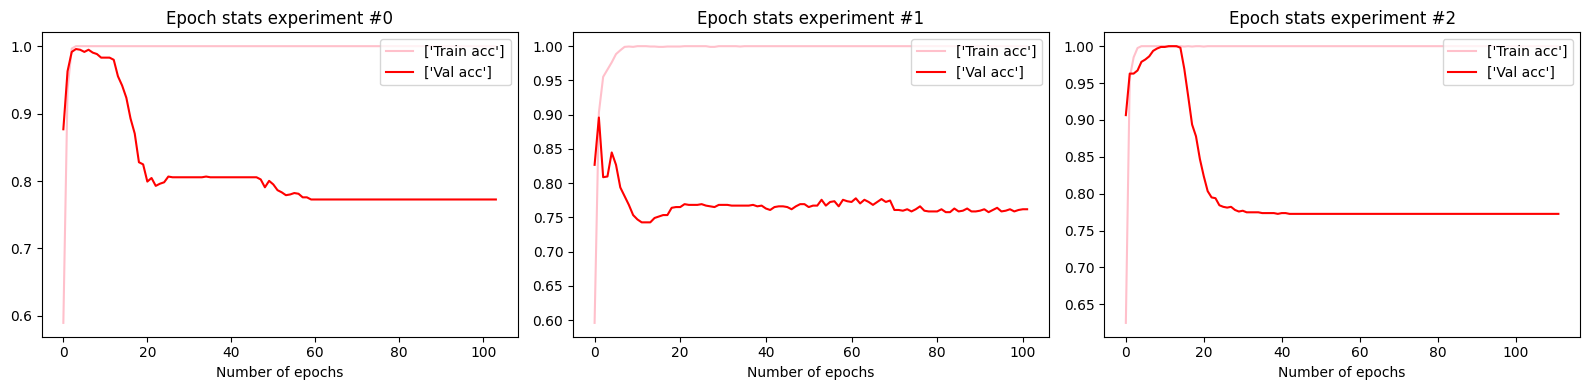

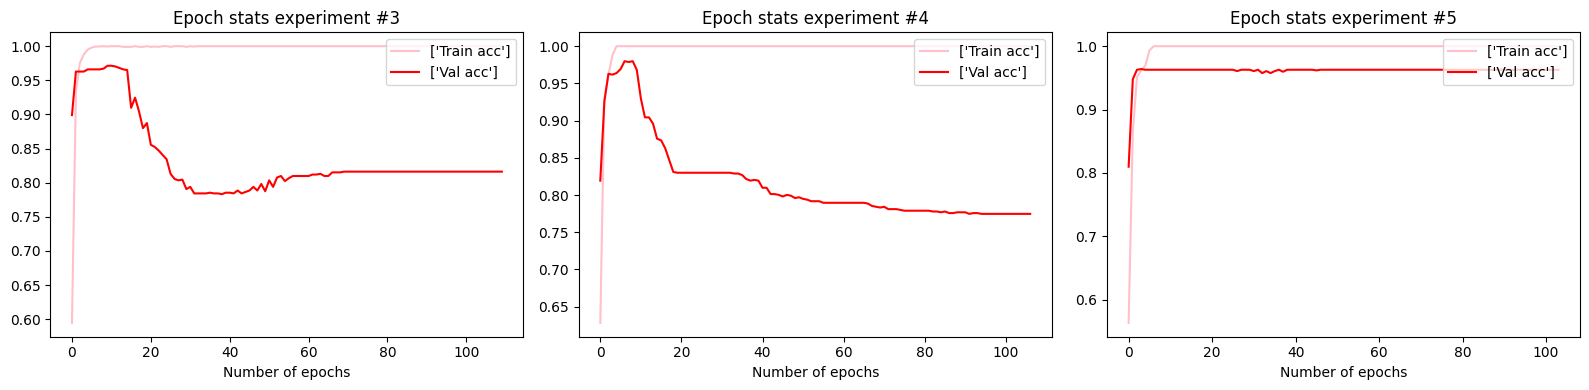

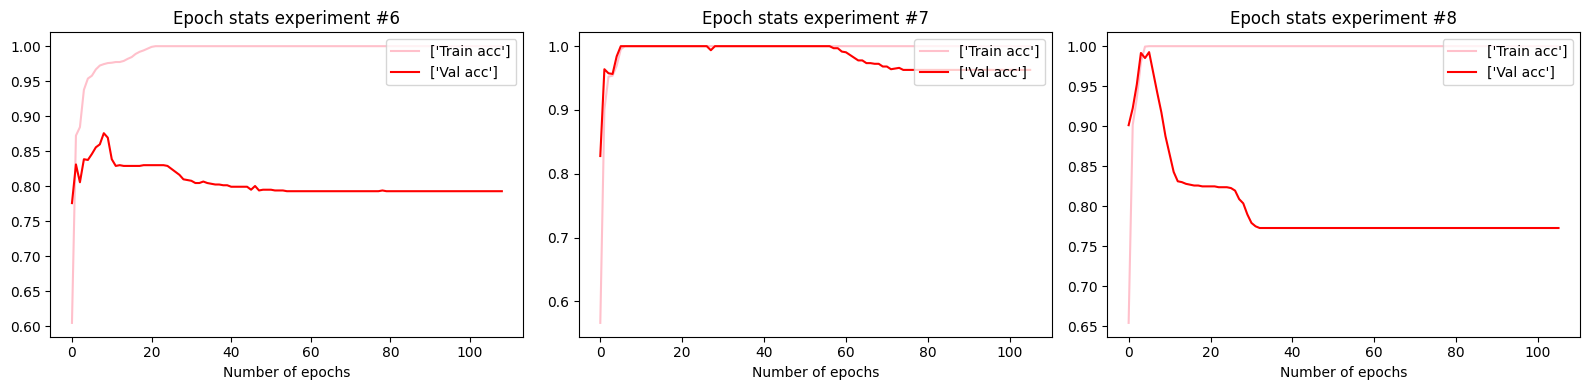

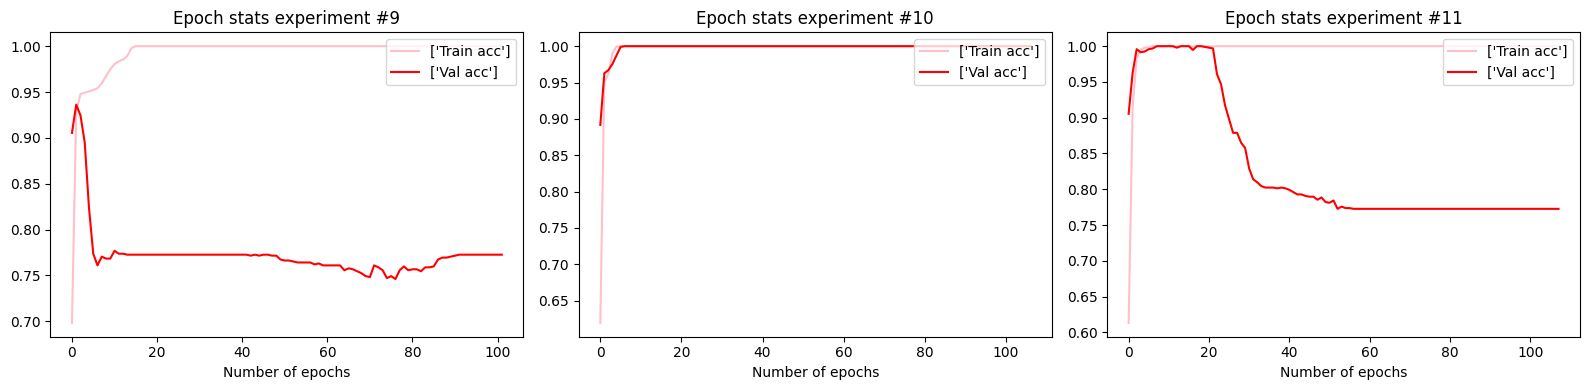

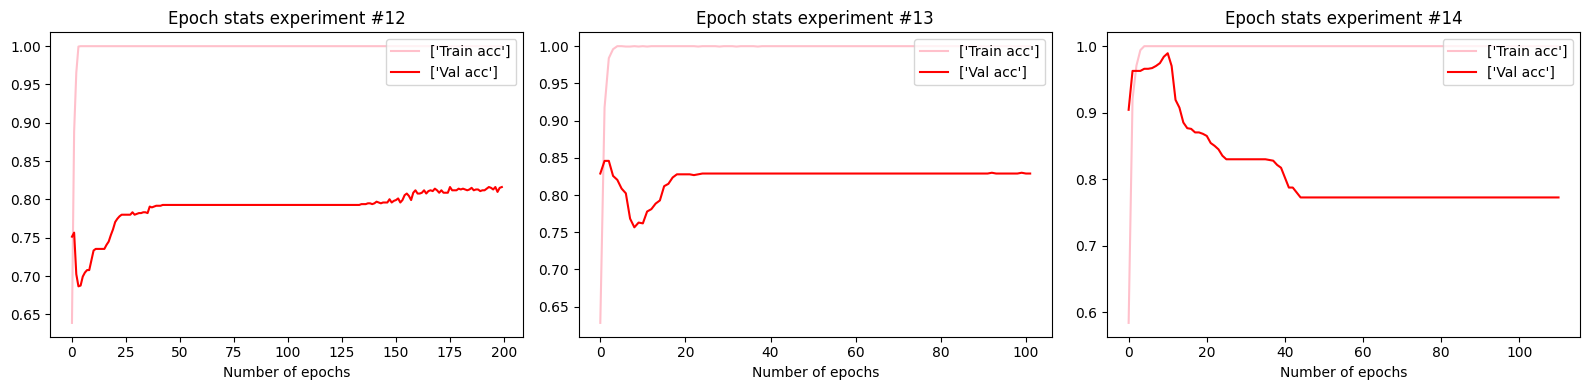

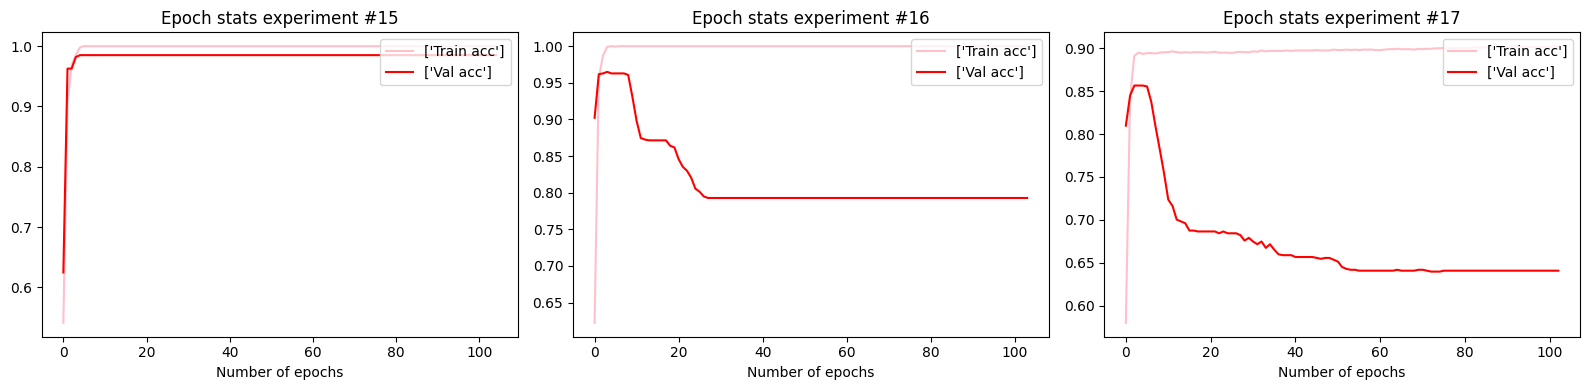

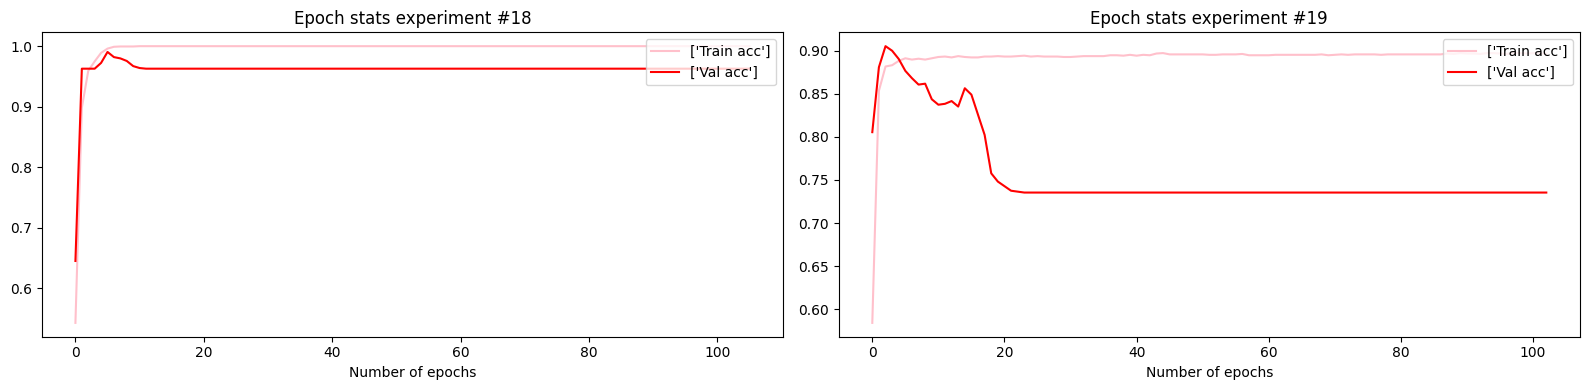

In [33]:
display_epochs_stats(cnn_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### LSTM

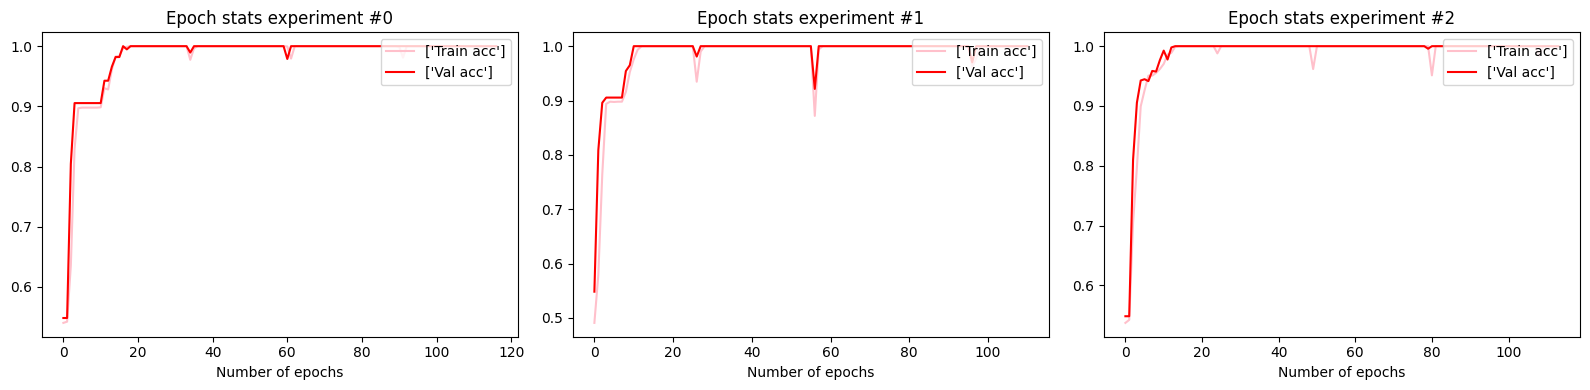

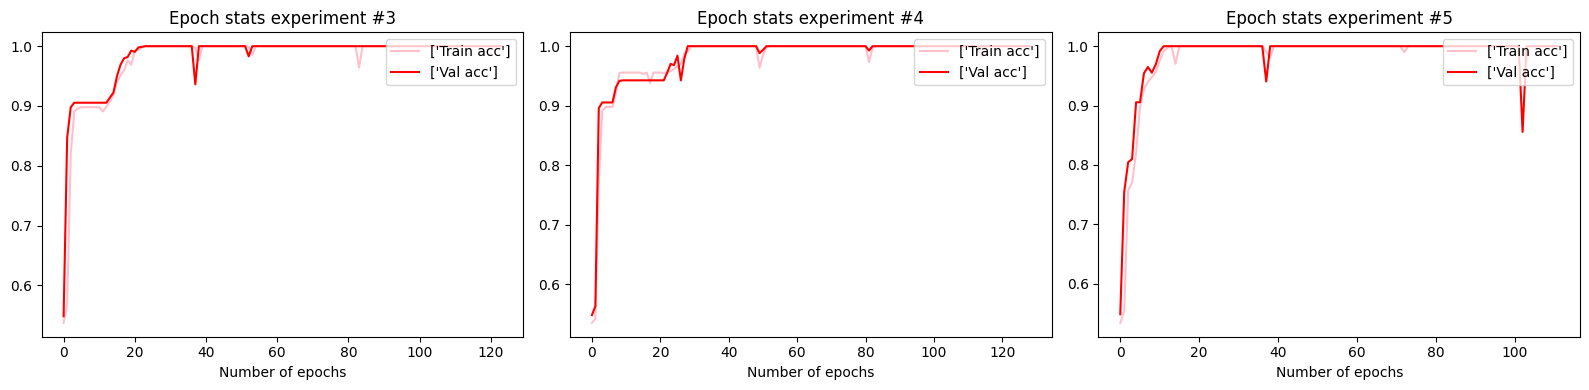

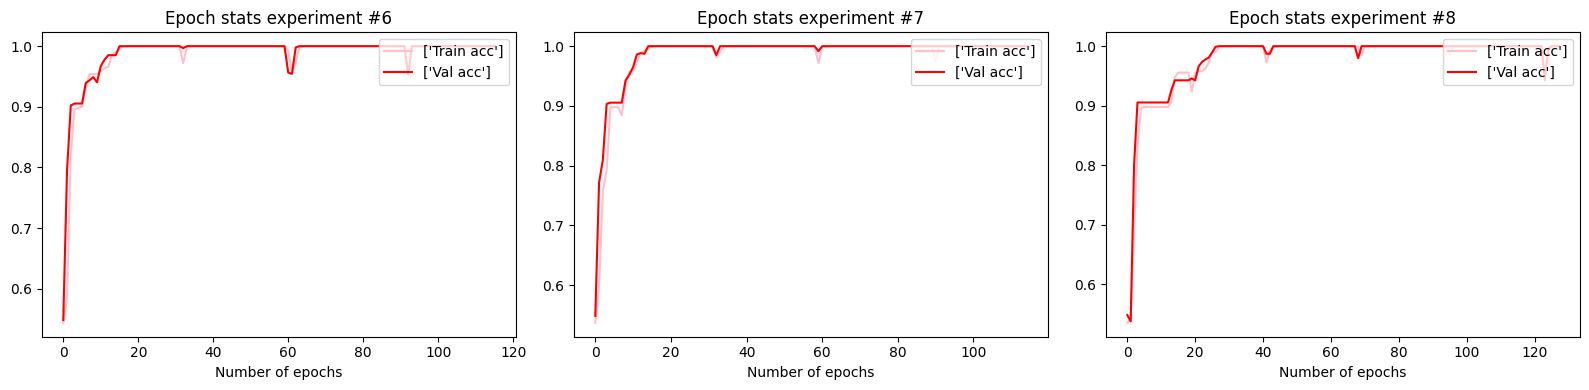

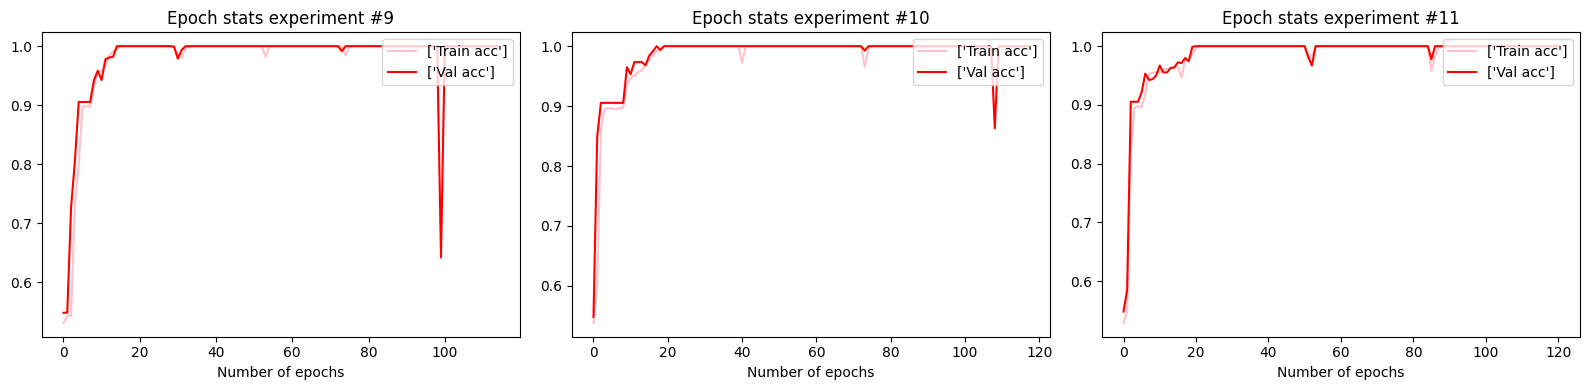

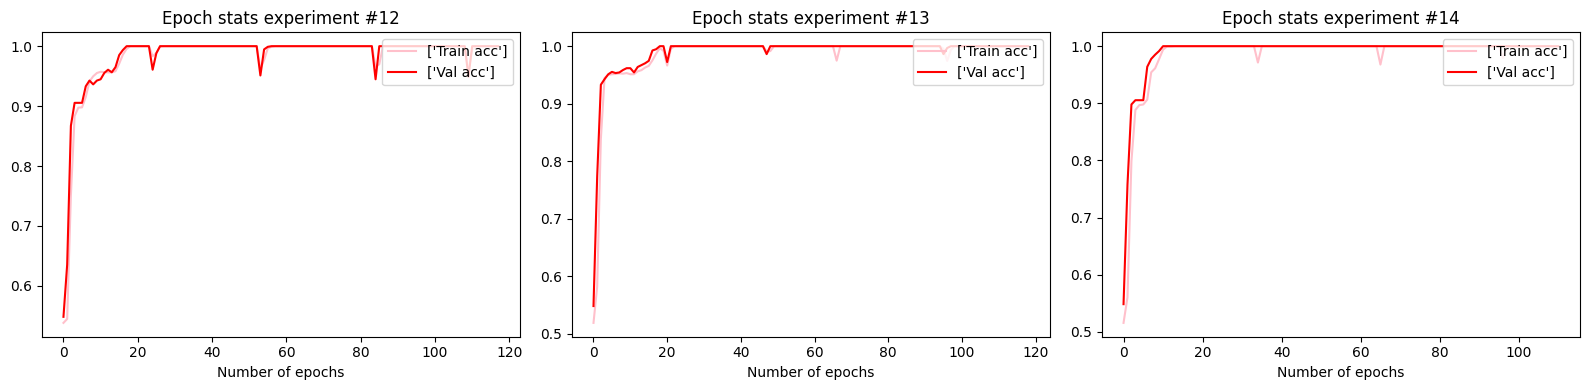

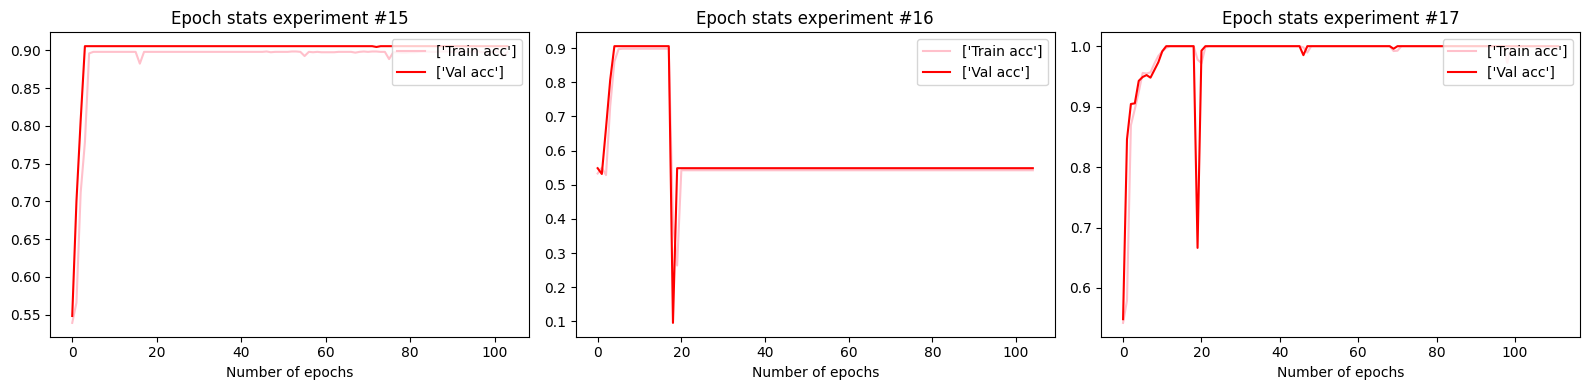

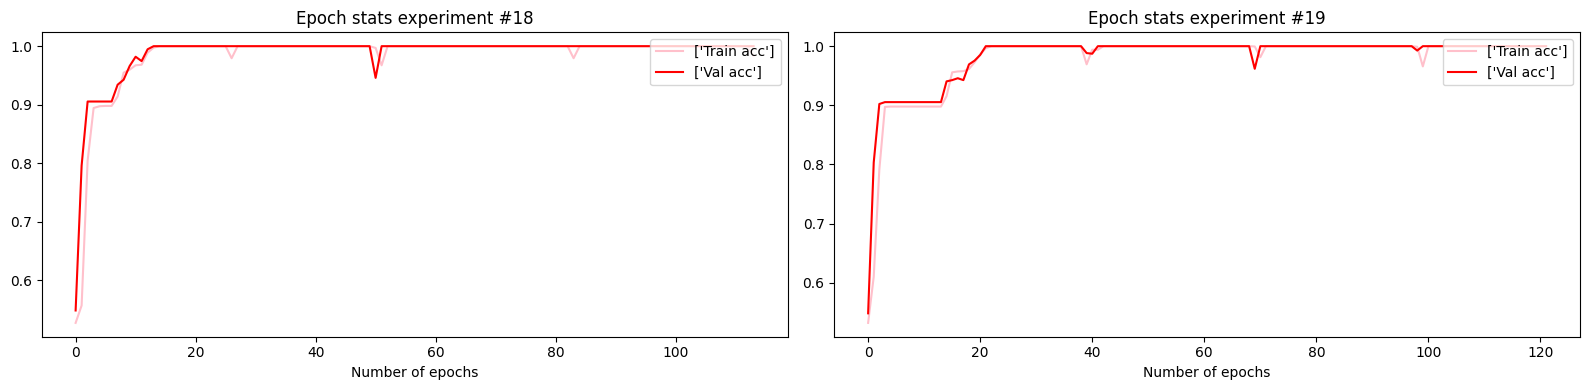

In [34]:
display_epochs_stats(lstm_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### DeepSets V1

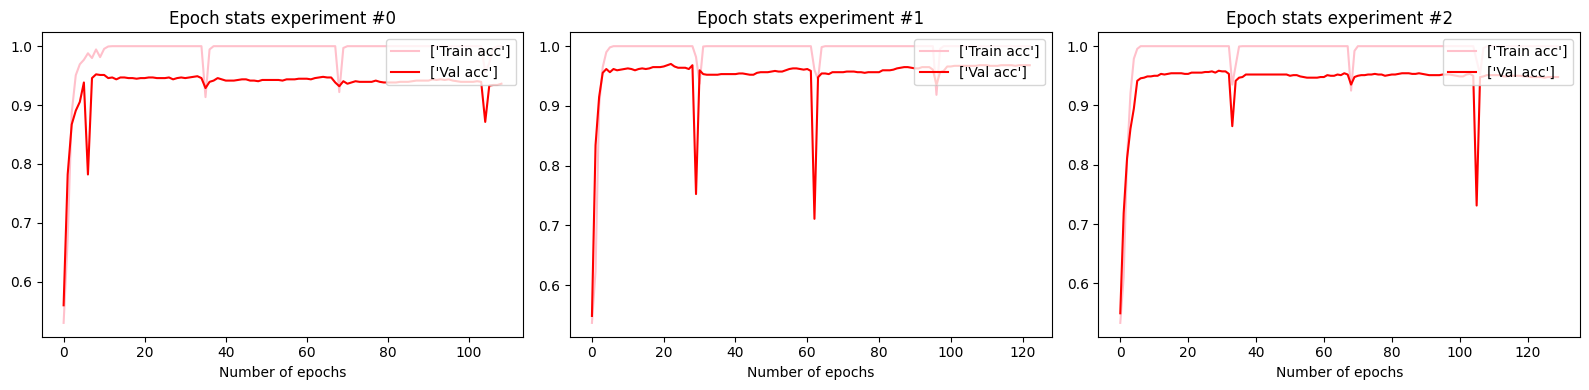

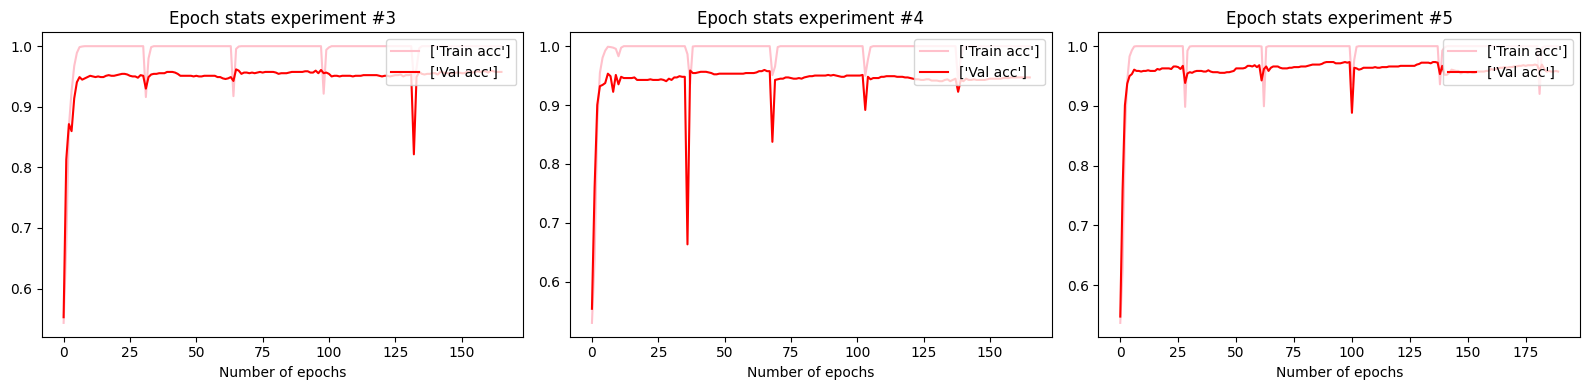

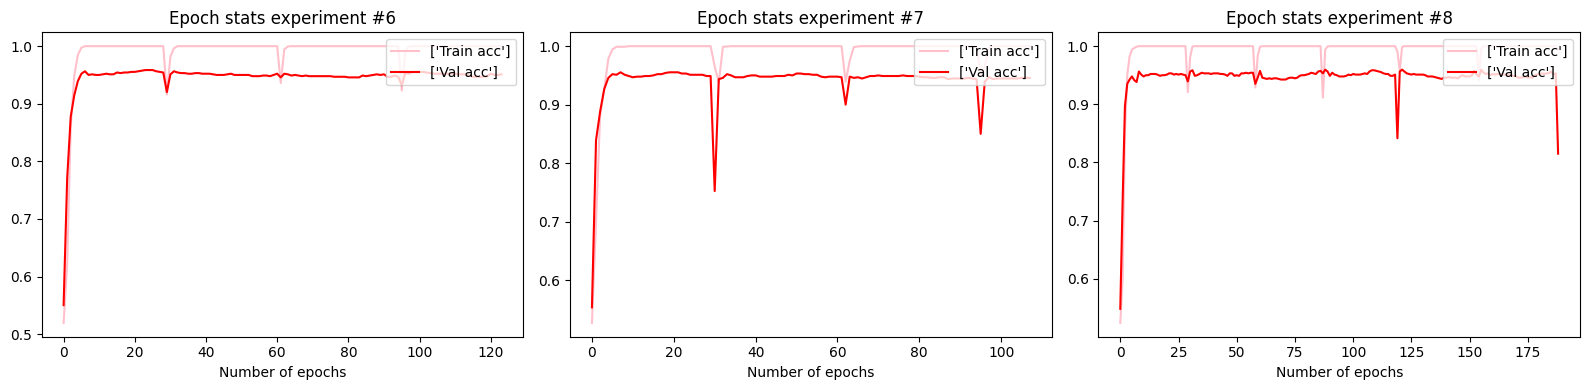

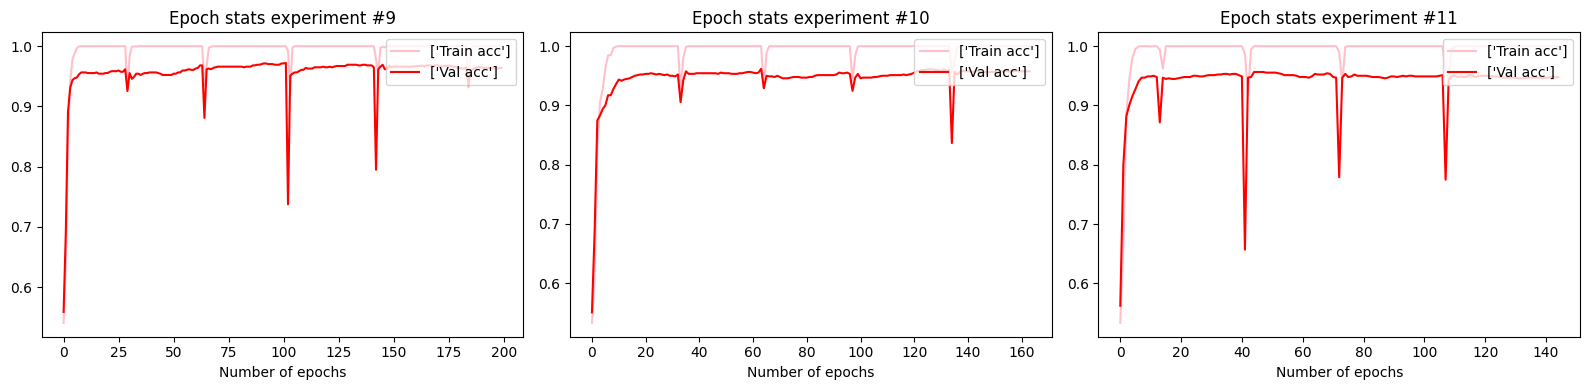

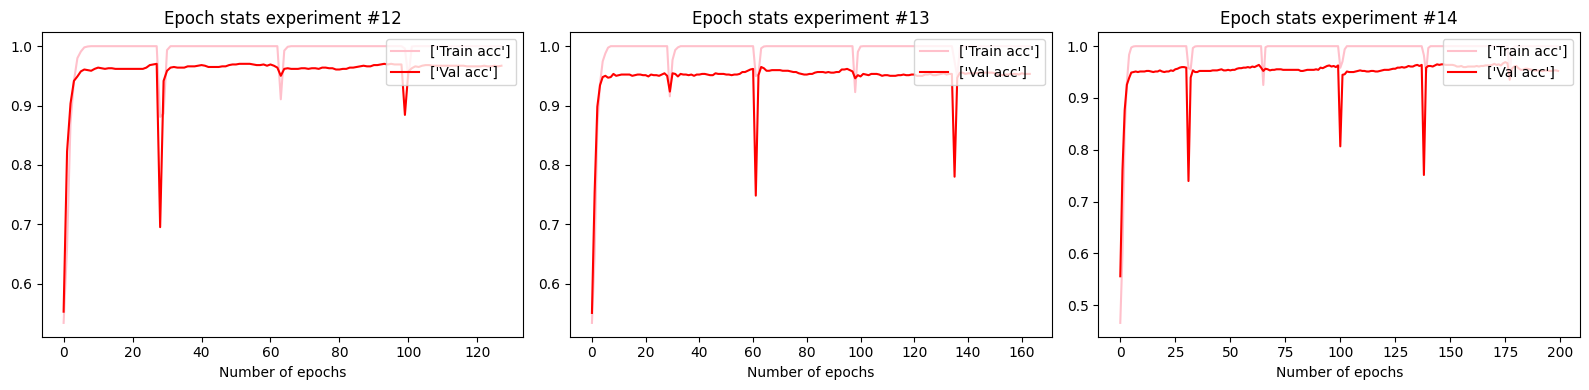

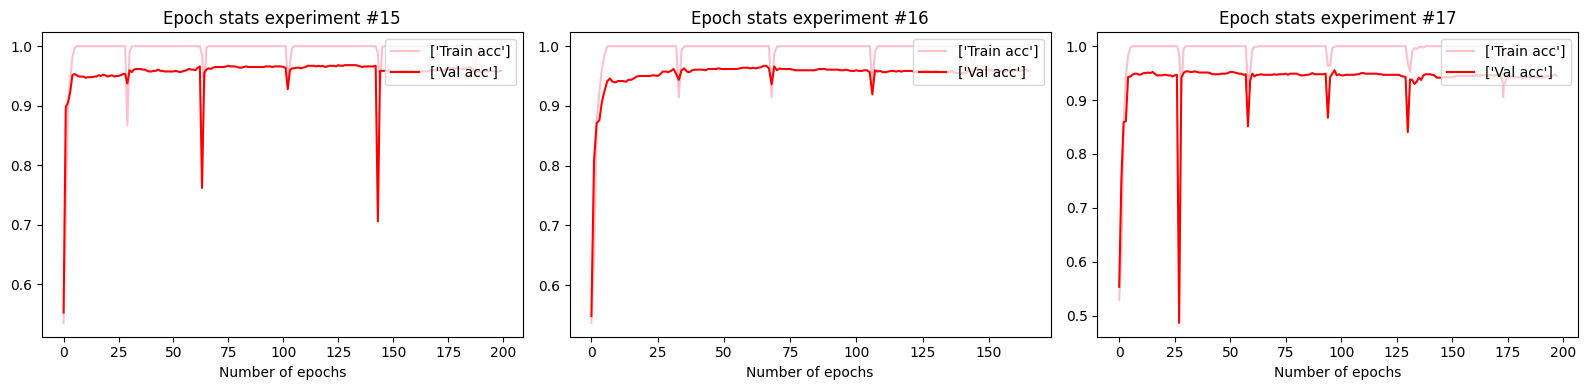

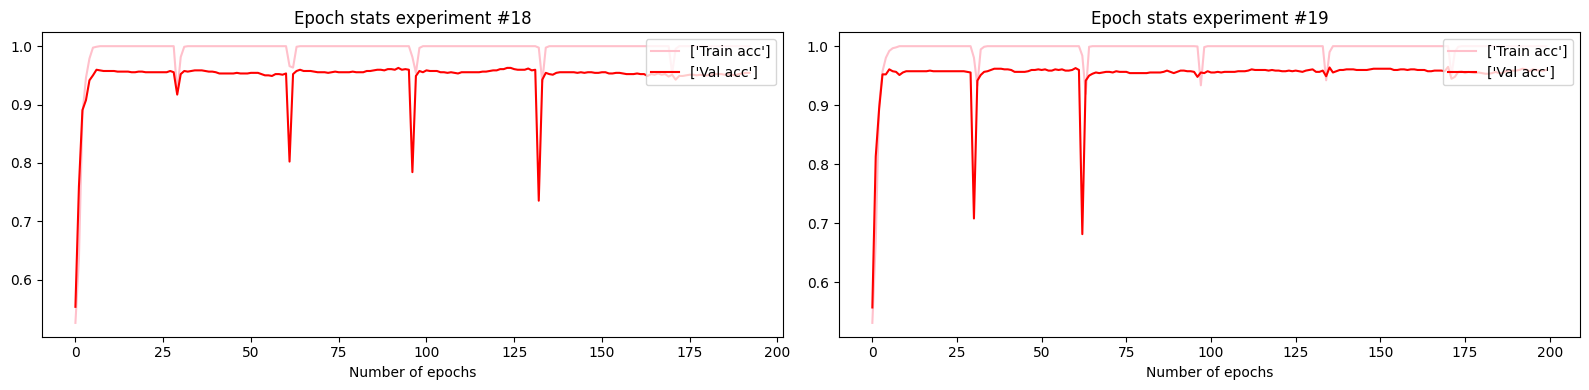

In [35]:
display_epochs_stats(deepset_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### DeepSets V2

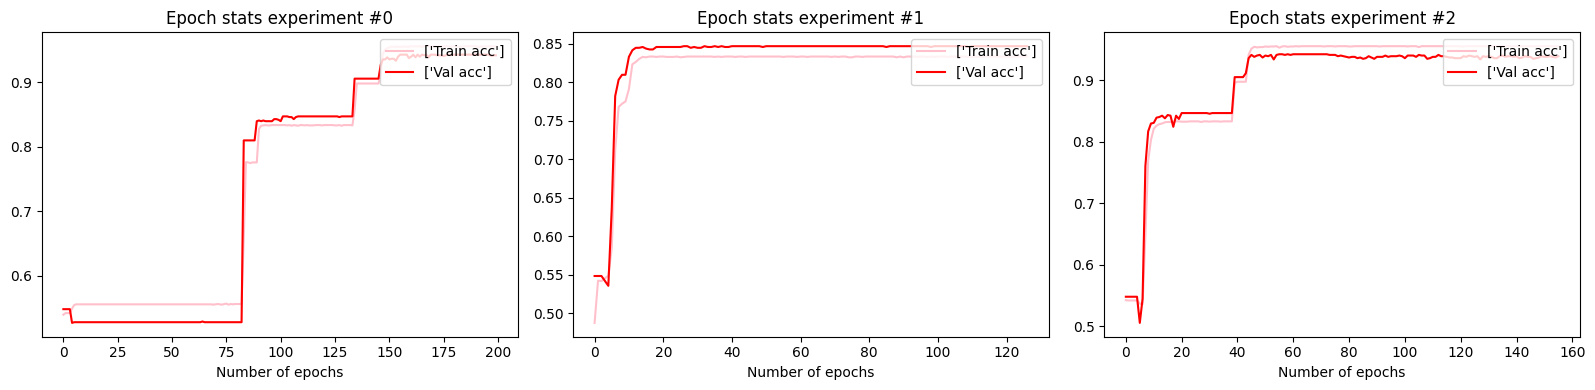

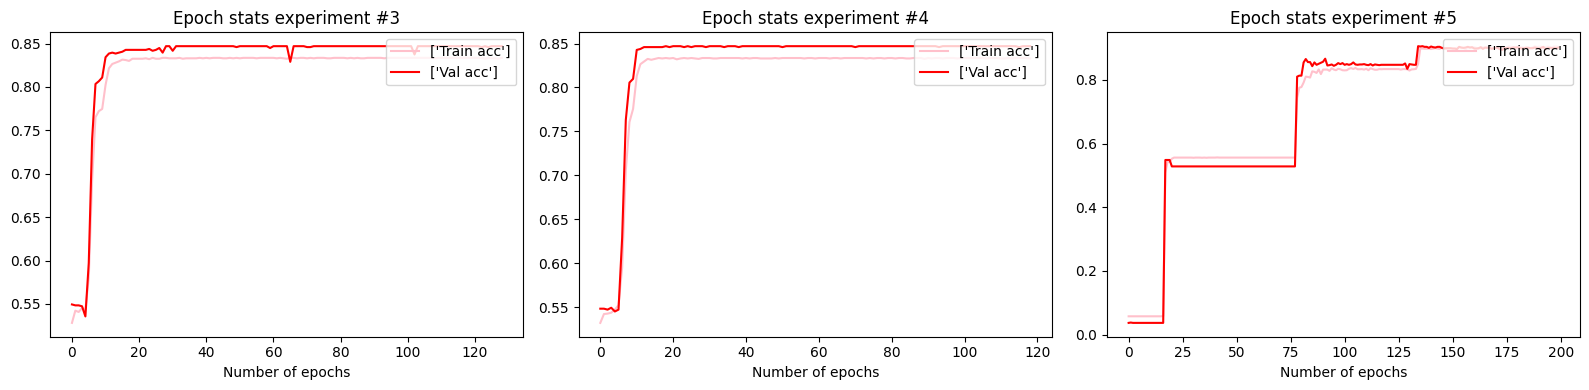

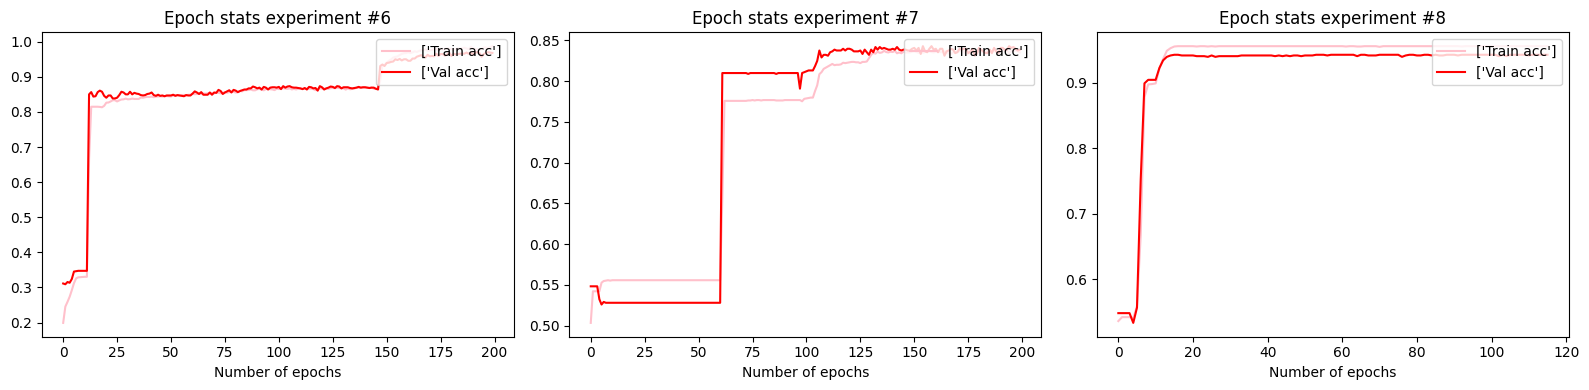

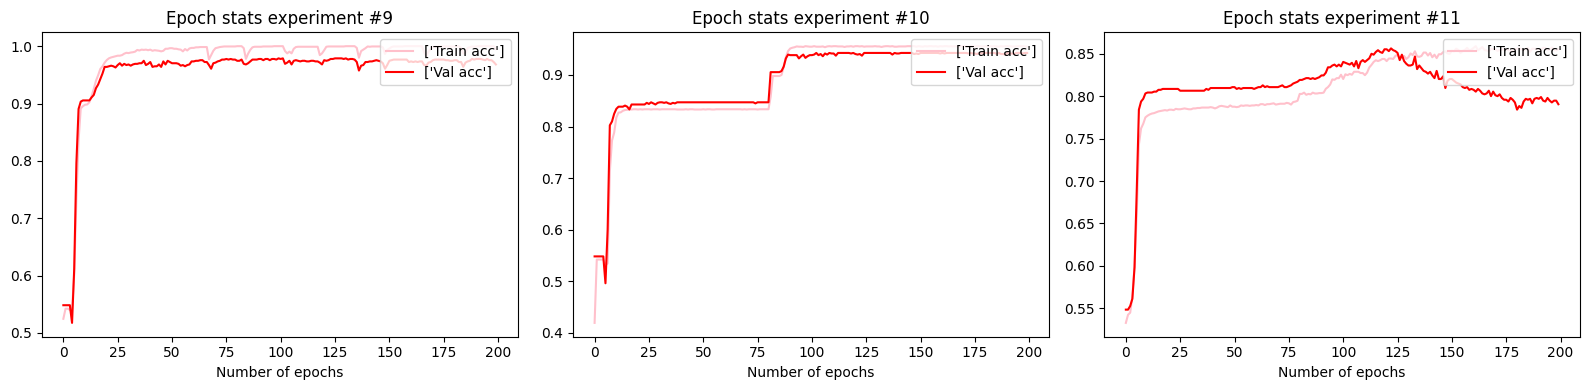

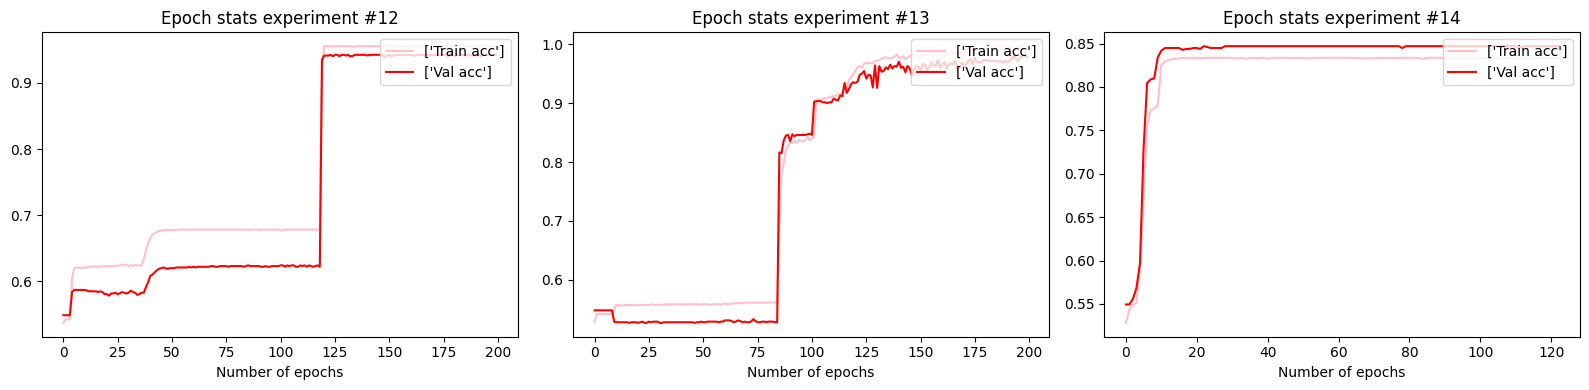

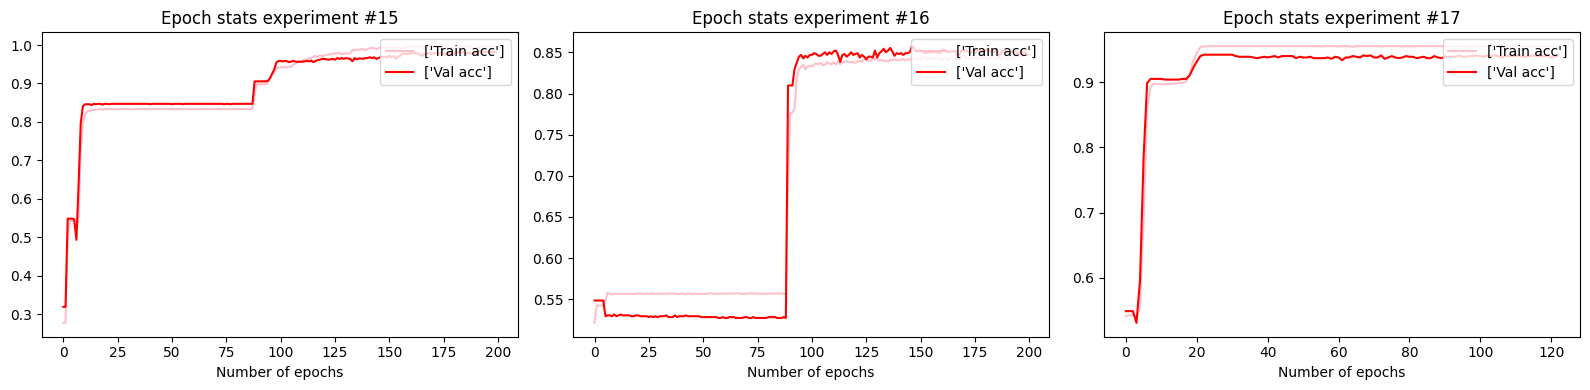

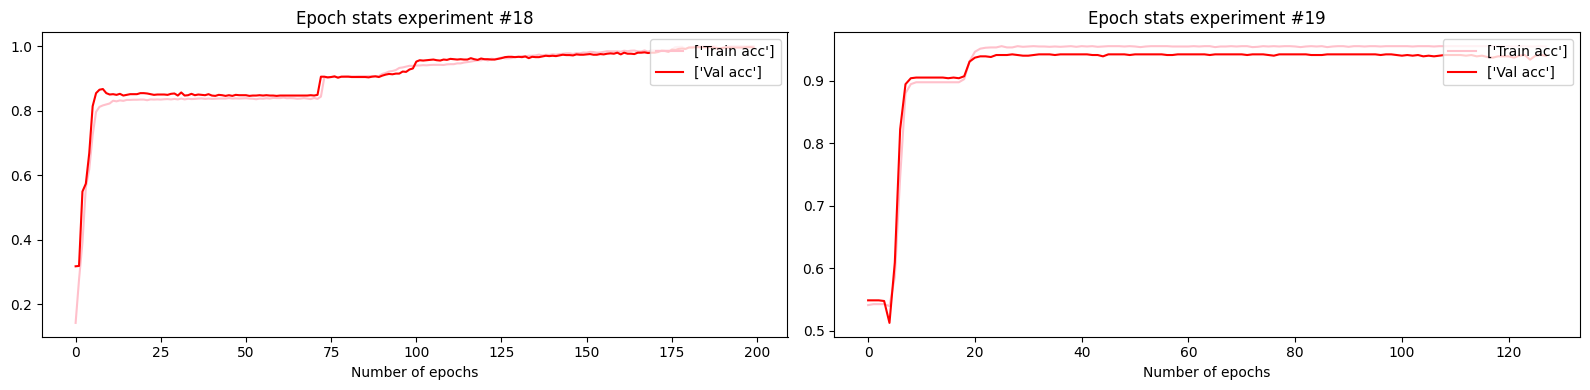

In [36]:
display_epochs_stats(deepsetv2_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

### FeedForward

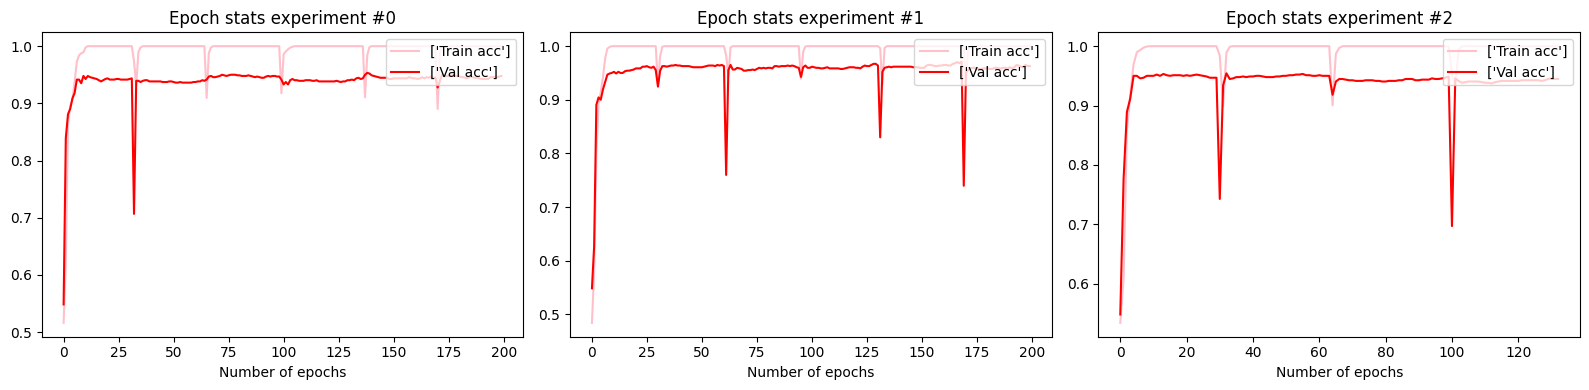

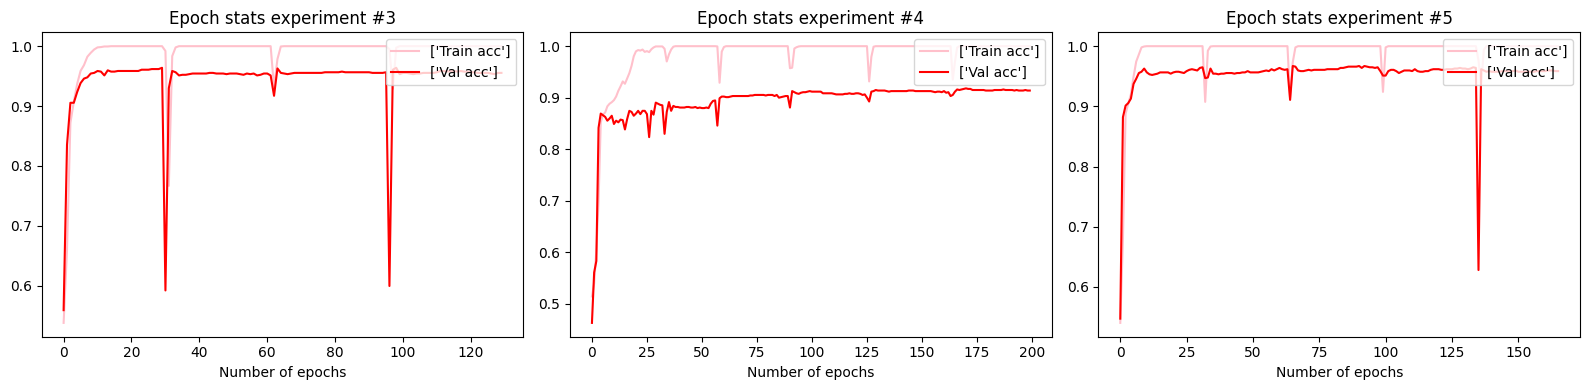

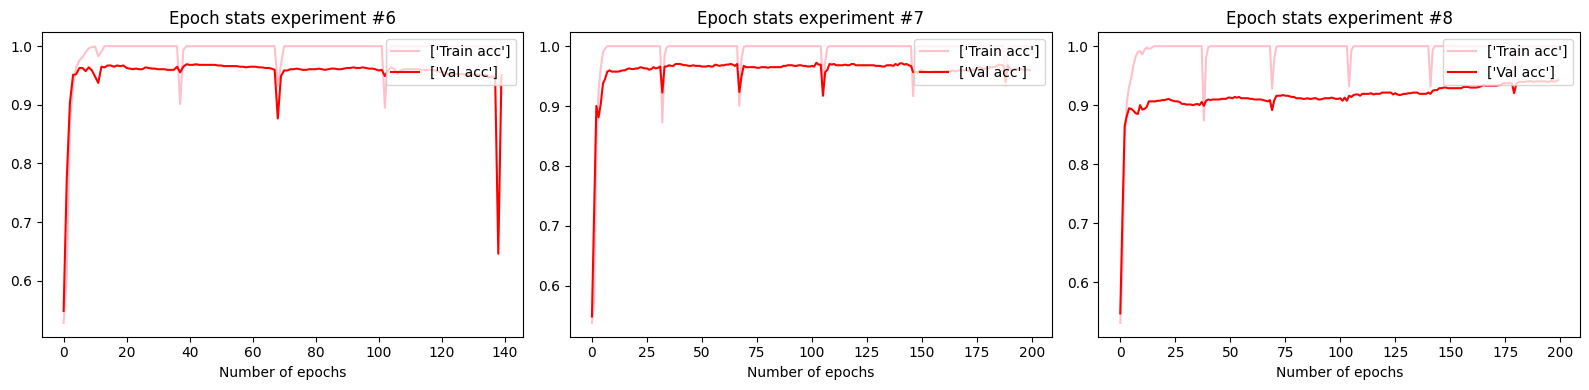

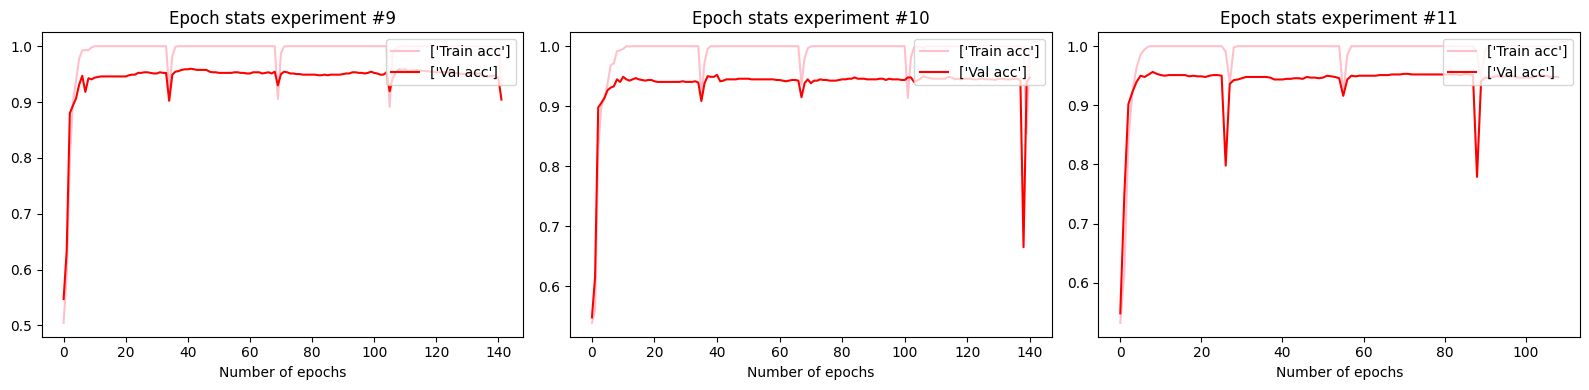

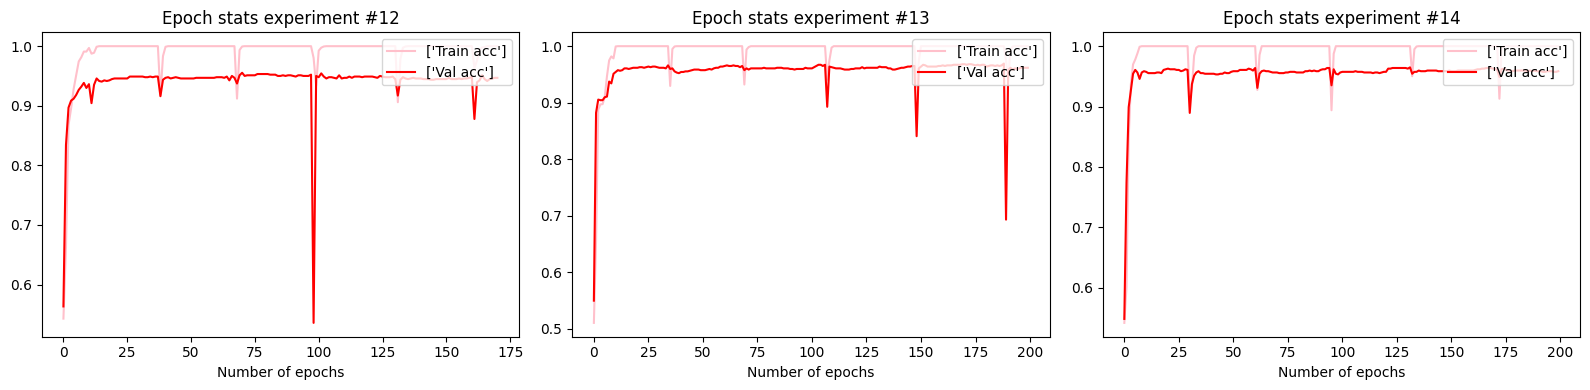

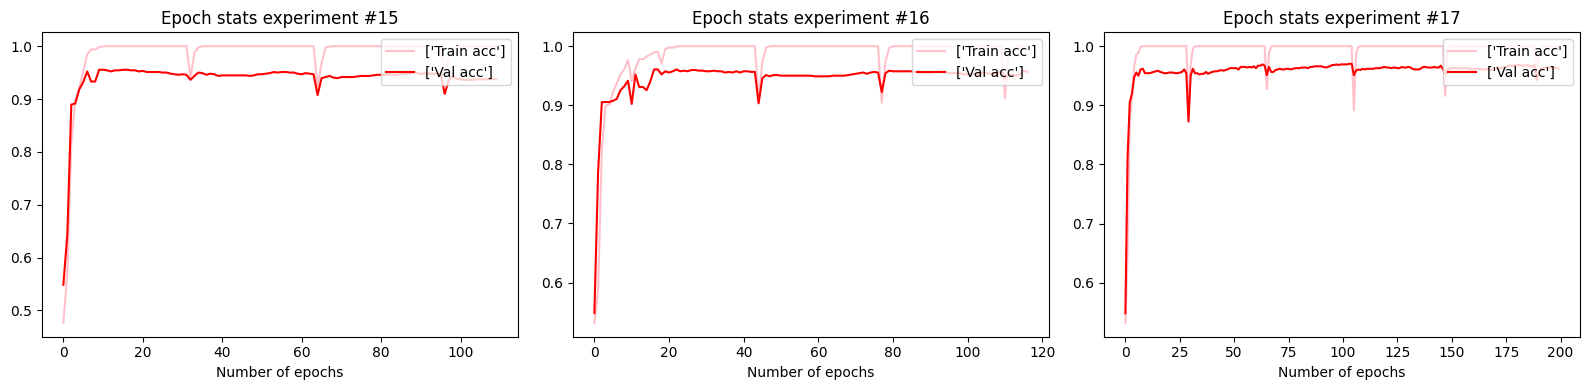

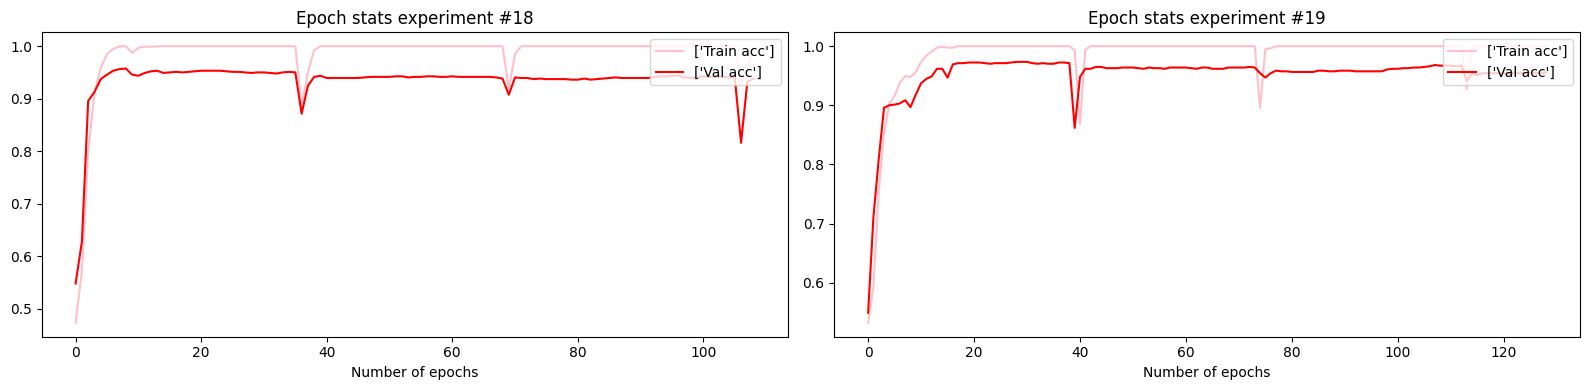

In [37]:
display_epochs_stats(feedforward_epoch_stats, num_experiments, display_train_loss=False, display_val_loss=False)

# Best performing models

In [8]:
best_lstm_model = LSTM_Model(data, 16, 32, 8).to(device)
best_lstm_model.load_state_dict(torch.load('./bestmodels/best_LSTM_model_' + experiment_name))
best_cnn_model = CNN_Model(data, 32, 64, 4, -1,).to(device)
best_cnn_model.load_state_dict(torch.load('./bestmodels/best_CNN_model_' + experiment_name))
best_deepset_model = DEEPSET_Model(data).to(device)
best_deepset_model.load_state_dict(torch.load('./bestmodels/best_DEEPSET_model_' + experiment_name))
best_deepsetv2_model = DEEPSETV2_Model(data).to(device)
best_deepsetv2_model.load_state_dict(torch.load('./bestmodels/best_DEEPSETV2_model_' + experiment_name))
best_feedforward_model = FEEDFORWARD_Model(data).to(device)
best_feedforward_model.load_state_dict(torch.load('./bestmodels/best_FEEDFORWARD_model_' + experiment_name))

<All keys matched successfully>

## Top wrong predictions for best performing CNN model

In [11]:
print_wrong_preds([get_wrong_predictions(best_cnn_model, x_test_cnn, y_test, test_original)], 10)

NameError: name 'x_test_cnn' is not defined

## Top wrong predictions for best performing LSTM model

In [45]:
print_wrong_preds([get_wrong_predictions(best_lstm_model, x_test_lstm, y_test, test_original)], top_k=10)

Top 10 false positives: 


Top 10 false negatives: 





## Top wrong predictions for best performing DeepSets V1 model

In [46]:
print_wrong_preds([get_wrong_predictions(best_deepset_model, x_test_normal, y_test, test_original)], top_k=10)

Top 10 false positives: 

_...__._w.u_.__, ,_d,r_.__,,__.__ | label: False | actual prediction: 0.9999977350234985
w_u.,_._...,,,., d,r_.,,,,_._,___ | label: False | actual prediction: 0.9999955892562866
._,,_.w.u.._._,, .,d,r....,,___., | label: False | actual prediction: 0.9999942779541016
,_..,.,.w_u,___. ,,_._.._..,d.r._ | label: False | actual prediction: 0.9999920129776001
._.__w_u...,_,,, ,,.d.r,_._..,.., | label: False | actual prediction: 0.999991774559021
,___.._,w_u_..,. d.r__,__.._,,,,_ | label: False | actual prediction: 0.9999898672103882
._.,_.,,_w.u,,._ _,,__,..,d.r..._ | label: False | actual prediction: 0.9999891519546509
._,w_u_,.,_..,__ .,.d.r,_,.,,._.. | label: False | actual prediction: 0.9999845027923584
w.u...._.___,.,_ .,d.r___,_,_,.__ | label: False | actual prediction: 0.9999843835830688
..,._,,,._w,u.__ ._d,r..,,,.,..,. | label: False | actual prediction: 0.9999823570251465

Top 10 false negatives: 

.._,.._.,..u.w_, _.,....,___,__r_ | label: True | actual p

## Top wrong predictions for best performing DeepSets V2 model

In [47]:
print_wrong_preds([get_wrong_predictions(best_deepsetv2_model, x_test_normal, y_test, test_original)], top_k=10)

Top 10 false positives: 


Top 10 false negatives: 

..,,_,__,.,u.w,. _.___,_d.r.._,,. | label: True | actual prediction: 0.5
_..u,w,,_.,____, ..,,,,_d,r,_.._. | label: True | actual prediction: 0.5
..___._.,.u_w.., _..__,_,,,__r_.. | label: True | actual prediction: 0.5
w.__,._._.____.. __,,.,_,r....... | label: True | actual prediction: 0.5
___,,..,,___.,__ ,_,_,r.,.,__.... | label: True | actual prediction: 0.5
,,,,.,..w_u,.,._ .._.___.,_.,__r. | label: True | actual prediction: 0.5
,,,,,_u.w._..._. ,d,r_..,,...,,,, | label: True | actual prediction: 0.5
._,__,...w,,,_,_ .,._d,r,,__,,.._ | label: True | actual prediction: 0.5
..,,.u,w_,.,,.__ .,.__,,r...,.,_. | label: True | actual prediction: 0.5
,,w.u__.,.,__.,. ,,_.._,r.___,_,, | label: True | actual prediction: 0.5




## Top wrong predictions for best performing Feedforward model

In [48]:
print_wrong_preds([get_wrong_predictions(best_feedforward_model, x_test_normal, y_test, test_original)], top_k=10)

Top 10 false positives: 

,___.._,w_u_..,. d.r__,__.._,,,,_ | label: False | actual prediction: 0.999924898147583
...,._,.._,,_w_u ._d.r,.,__,_.,,, | label: False | actual prediction: 0.9998886585235596
,,,w,u.____,__,. ,,d,r_,.,_,,,._. | label: False | actual prediction: 0.9998842477798462
_,.,.._,.,,,,w.u ,__d_r,.._,_,,__ | label: False | actual prediction: 0.9998492002487183
,,_,_.w,u,.,_,._ ,.,_,d_r...__,_, | label: False | actual prediction: 0.9998317956924438
.___w_u.____._., d_r,.,,__.._____ | label: False | actual prediction: 0.9998273253440857
w.u...._.___,.,_ .,d.r___,_,_,.__ | label: False | actual prediction: 0.9998219609260559
._,,_.w.u.._._,, .,d,r....,,___., | label: False | actual prediction: 0.9997498393058777
_.,.,,.,w_u._,_. ,_._,d_r.,_,,.__ | label: False | actual prediction: 0.9997337460517883
_..__w.u,__.,_._ __.._,_..d.r.._. | label: False | actual prediction: 0.9997050166130066

Top 10 false negatives: 

,,...w.u_..,__,. ._,.,_.,.r.._.,, | label: True | actual p

# Saving Notebook State

In [49]:
import dill
dill.dump_session('notebook_env_' + experiment_name + '.db')

# Loading Notebook State

In [50]:
import dill
experiment_name = "interop_1"
# dill.load_session('notebook_env_' + experiment_name + '.db')

In [ ]:
import shap

In [136]:

print("Forma de shap_values:", shap_values.shape)
print("Forma de x_train:", x_train.shape)

print("\nForma de shap_values[0]:", shap_values[0].shape)
print("Forma de x_train[:10]:", x_train[:10].shape)

Forma de shap_values: (10, 384, 4)
Forma de x_train: (1988, 384)

Forma de shap_values[0]: (384, 4)
Forma de x_train[:10]: (10, 384)


shap_values[0].shape = (384, 4):

    Esto indica que shap_values[0] tiene 384 filas y 4 columnas. En este caso, 384 puede representar el número de características (features) o variables de entrada en tu modelo, y 4 podría indicar el número de clases en un problema de clasificación multiclase.
    En otras palabras, cada fila de shap_values[0] corresponde a un valor SHAP para una característica específica, y cada columna corresponde a una clase en un problema de clasificación multiclase.

    

x_train[:10].shape = (10, 384): Esto indica que en x_train[:10], hay 10 muestras (ejemplos) y 384 características por muestra.
 La diferencia es que parece que los datos de entrada están organizados de manera diferente: en lugar de tener 384 muestras y 4 características, tienes 10 muestras y 384 características por muestra.

In [ ]:
#  realiza la predicción sobre un conjunto de datos 
def predict_fn(x_train):
    best_lstm_model.eval()  # Establecer el modelo en modo evaluación (sin entrenamiento)
    
    
    x = data.to_lstm_format(x_train)  # Convertir a la forma LSTM 

    # Realizar la predicción y retornar los resultados sin los gradientes
    #Esto es importante porque durante la predicción, no necesitas actualizar los pesos del modelo (solo estás haciendo inferencia), por lo que puedes desactivar el cálculo de gradientes para ahorrar memoria y hacer que el proceso sea más rápido.
    with torch.no_grad():
        output = best_lstm_model(x[0], x[1], x[2])  # Pasar las tres secuencias al modelo LSTM
        return output.detach().cpu().numpy()  # Separar del grafo de gradientes y convertir a numpy (que es el formato que SHAP espera.)






In [ ]:
#El explicador utiliza un subconjunto de tus datos de entrenamiento (las primeras 100 muestras en este caso) para aproximar la influencia de las características ¿operaciones no? en las predicciones.
explainer = shap.KernelExplainer(predict_fn,  x_train[:100])

# Obtener los valores SHAP para un pequeño conjunto de datos (10 muestras en este caso)
#Aquí calculamos los valores SHAP para un pequeño subconjunto de los datos de entrada. Los valores SHAP indican cuánto contribuye cada característica  a la predicción final del modelo para cada instancia.
#Esto generará una explicación local de cómo las características de estas 10 muestras influyen en las predicciones.
shap_values = explainer.shap_values(x_train[:10])  # Cambiar el número según el tamaño que quieras analizar


  0%|          | 0/10 [00:00<?, ?it/s]

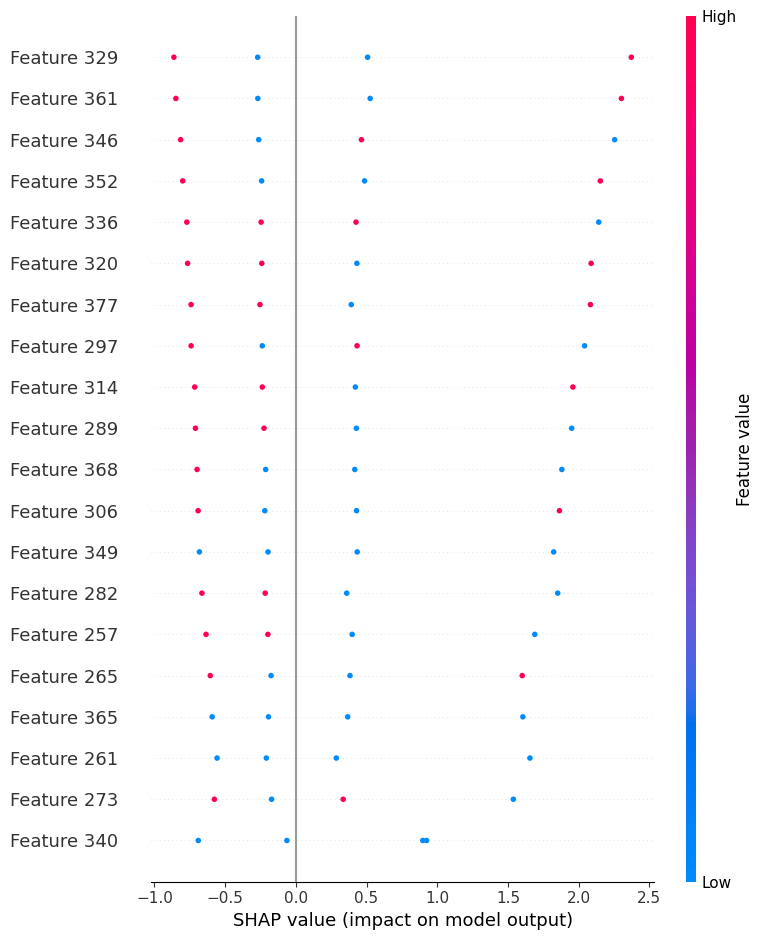

In [ ]:
# Visualización de los valores SHAP para la primera clase (para clasificación multiclase)
#shap.summary_plot(shap_values[0], x_train[:10])  # Primer conjunto de valores SHAP (para la primera clase)

# Transponer shap_values[0] si es necesario
shap_values_reshaped = shap_values[0].T  # Cambiar de (384, 4) a (4, 384)

# Transponer x_train[:10] si es necesario
x_train_reshaped = x_train[:4] # Cambiar de (10, 384) a (384, 10)

# Ahora visualizamos los valores SHAP con los datos reshaped
#Este gráfico muestra cómo las diferentes características influyen en la predicción y qué tan importante es cada característica para cada clase (por ejemplo, el tipo de error que ocurrió). 
# El gráfico organiza las características por importancia y muestra sus contribuciones a la predicción.
shap.summary_plot(shap_values_reshaped, x_train_reshaped)


Cuando se usa SHAP para explicar las predicciones de un modelo, los valores SHAP tienen una relación directa con las características de los datos de entrada. 
La forma de los datos de entrada debe coincidir con la forma de los valores SHAP para poder visualizarlos correctamente.

Este ajuste hace lo siguiente:

   shap_values_reshaped: Transponemos los valores SHAP de (384, 4) a (4, 384) para que cada fila represente una muestra.
   x_train_reshaped: Seleccionamos las primeras 4 muestras de x_train con x_train[:4] para coincidir con el número de muestras en shap_values.

In [ ]:
#shap_values_reshaped = shap_values[0].T  # Transponer los valores SHAP si es necesario
print("Forma de shap_values_reshaped:", shap_values_reshaped.shape)

# Ahora, asegúrate de que x_train[:10] esté en el formato correcto
print("Forma de x_train[:10]:", x_train[:10].shape)

Forma de shap_values_reshaped: (4, 384)
Forma de x_train[:10]: (10, 384)


Parámetros principales de shap.summary_plot:

    shap_values: Los valores SHAP que explican las predicciones del modelo. Pueden ser obtenidos mediante el explicador de SHAP.
    features: El conjunto de características (entradas) correspondientes a las observaciones para las cuales se generaron los valores SHAP.
    max_display: Especifica cuántas características mostrar en el gráfico. Si no se proporciona, se muestran todas las características.
    plot_type: Permite elegir entre diferentes tipos de gráficos, como "dot", "violin", etc. El valor predeterminado es "dot".
    color: Color de las características en el gráfico.
    title: Título del gráfico.

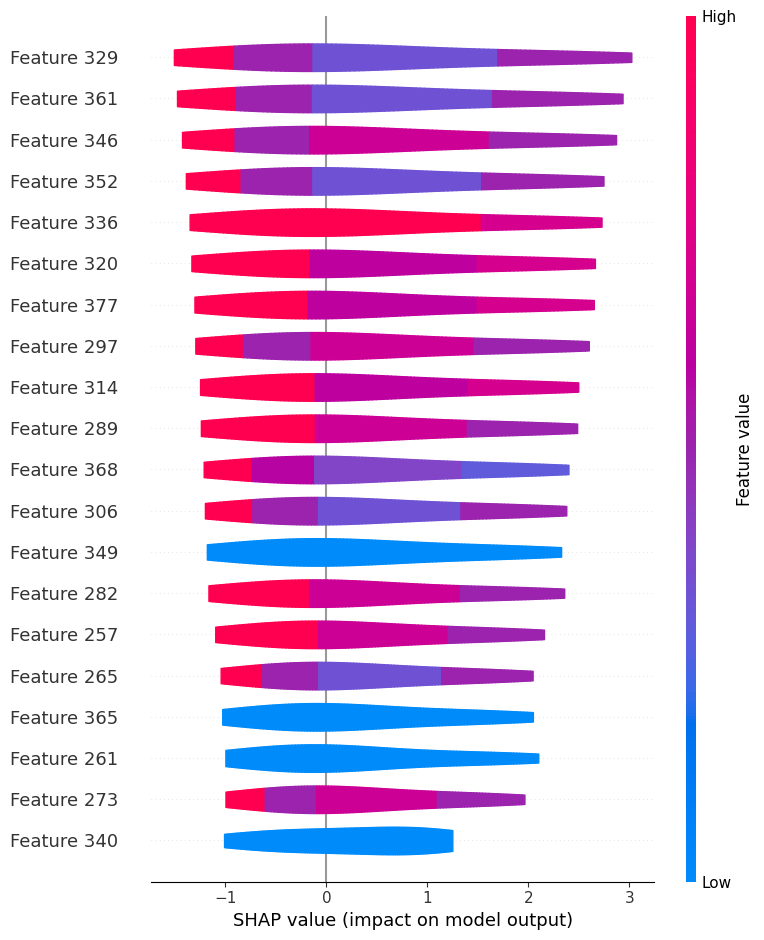

In [119]:
shap_values_reshaped = np.array(shap_values_reshaped, dtype=np.float64)
x_train_reshaped = np.array(x_train_reshaped, dtype=np.float64)

shap.summary_plot(shap_values_reshaped, x_train_reshaped, plot_type="violin")


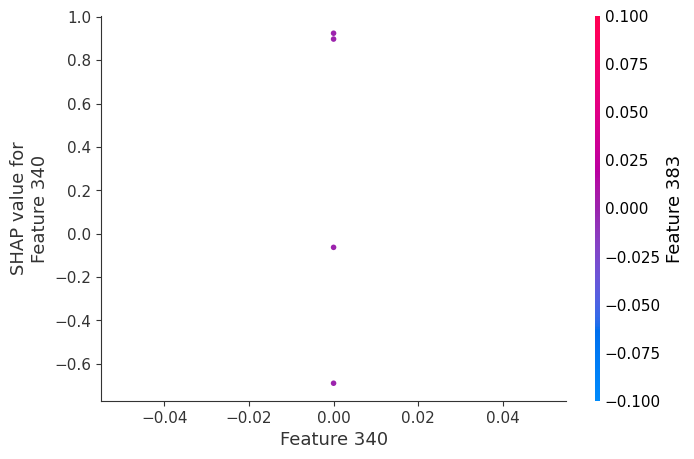

In [122]:
shap.dependence_plot("Feature 340", shap_values_reshaped, x_train_reshaped)

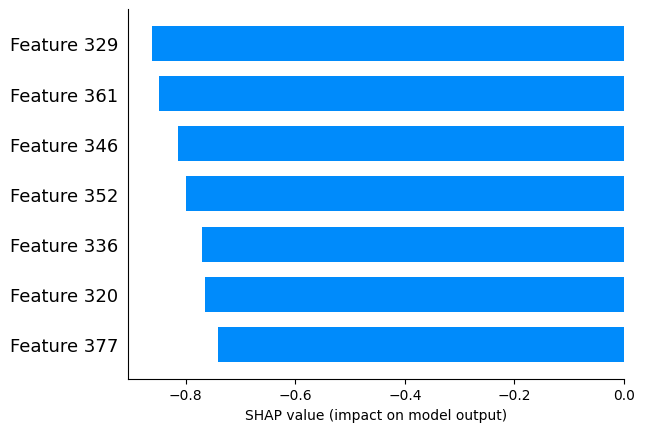

In [126]:
shap.bar_plot(shap_values_reshaped[0])

Resumen de tipos de visualizaciones disponibles:

    summary_plot: Distribución general de los valores SHAP.
    force_plot: Muestra cómo las características afectan la predicción de una sola muestra.
    dependence_plot: Muestra la relación entre características y valores SHAP.
    interaction_plot: Muestra la interacción entre dos características.
    bar_plot: Muestra la importancia de cada característica.
    shapley_values_plot: Muestra la contribución de las características.
    contribution_plot: Muestra cómo las características contribuyen a la predicción.